In [13]:
#extra-wide (temp) viewing
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

In [14]:
%pylab inline
from __future__ import division
from IPython.core.display import HTML
from matplotlib import dates
from sys import path
import time
import numpy as np
from datetime import datetime, timedelta
from pandas import date_range, DataFrame, Panel, set_option, read_csv, read_pickle, to_datetime
from pandas import Series, isnull, TimeGrouper, DatetimeIndex, notnull, Index
from pandas import read_pickle, read_excel, ExcelFile
import statsmodels.api as sm
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split


Populating the interactive namespace from numpy and matplotlib


/home/scott/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# This notebook deals with measuring the accuracy and processing the provenance/diagnostic information

## load and analyze best of provenance/diagnostics (needs pickle_puller)

In [15]:
def pickles_puller(source_id):
    """
    given the source_id int, this loads and returns the 
    prediction and provenance results
    
    """
    feed_path ='/home/scott/Desktop/CAPSTONE/feeds/feed_'
    #"/Users/cclarke/Desktop/Desktop - balle d'argent/ClickFox/Galvanize 2017 Capstone/feed_"
    #   try:
    this_prediction_panel = pd.read_pickle(feed_path  + source_id+ '_t_60_f_14_forecast.pickle')
    this_provenance_panel = pd.read_pickle(feed_path  + source_id+ '_t_60_f_14_provenance.pickle')

    return this_prediction_panel, this_provenance_panel

#### helpers to load the panels (prediction and prov/diags) and best choices to compare stats components

In [16]:
source_id = 0
this_pred, this_prov = pickles_puller('0')

def pickles_puller(source_id):
    """
    given the source_id int, this loads and returns the 
    prediction and provenance results
    
    """
    feed_path ='/home/scott/Desktop/CAPSTONE/feeds/feed_'
#     try:
    this_prediction_panel = pd.read_pickle(feed_path  +source_id+ '_t_60_f_14_forecast.pickle')
    this_provenance_panel = pd.read_pickle(feed_path  +source_id+ '_t_60_f_14_provenance.pickle')

    return this_prediction_panel, this_provenance_panel

In [17]:
source_ids = [str(x) for x in range(0,10)]
pred_panels = dict()
prov_panels = dict()
for s_id in source_ids:
    pred_panels[int(s_id)], prov_panels[int(s_id)] = pickles_puller(s_id)


In [18]:
this_pred = pred_panels[0] #fills in the this_pred throughout the following code
# def prediction_day_puller(int, prediction string)
feeds = [x for x in range(10)]
pred_dates = ['p0','p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13']
p_preds_X_df_dict = {}
for num in feeds:
    p_preds_X_df_dict[num] = dict()
    for p in pred_dates:
        p_preds_X_df_dict[num][p] = pred_panels[num].minor_xs(p).dropna() #pulls the p(0-13) predictions for each feed. It also drops NaNs from first 16 rows 
#these are my X values

In [19]:
#pulls the raw data for each feed, our target
feeds = [x for x in range(10)]
raw = ['this_data']
p_preds_y_df_dict = {}
for num in feeds:
    for p in raw:
        p_preds_y_df_dict[num] = pred_panels[num].minor_xs(p).drop(['cycle_series','differenced_1_data','differenced_1_cycle','differenced_2_data','differenced_2_cycle'], axis = 1)
    

In [20]:
#drops the first 16 rows so it matches the shape of the X data (remember there are no predictions for the first few weeks the models were training)
for x in p_preds_y_df_dict:
    p_preds_y_df_dict[x].drop(p_preds_y_df_dict[x].index[:15], inplace=True)

In [21]:
# find the mean for each column in each feed for each prediction, the idea is to remove outliers by finding items that are greater than 3x the mean
feeds = [x for x in range(10)]
pred_dates = ['p0','p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13']
p_preds_X_dfs_cleaned = {}
for feed in feeds: #feed
    p_preds_X_dfs_cleaned[feed] = dict()
    for pred in pred_dates:#prediction
        p_preds_X_dfs_cleaned[feed][pred] = p_preds_X_df_dict[feed][pred]
        for x in p_preds_X_df_dict[feed][pred].columns: #column 
            df_x = p_preds_X_df_dict[feed][pred][x]
            for i, cell in enumerate(df_x):
                if abs(cell-df_x.mean()) > 3*(df_x.std()):
                    p_preds_X_dfs_cleaned[feed][pred][x][i] = df_x[i-1]
#                     print(cell)
#             cleaned_columns.append(df_x)

In [22]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import AdaBoostRegressor
#from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

ValueError: Shape of passed values is (87, 87), indices imply (1, 87)

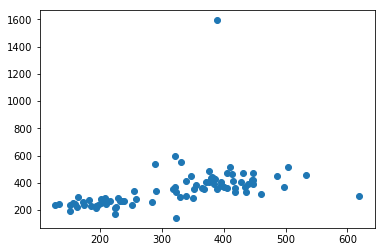

In [23]:
neural_net = MLPRegressor()
X = p_preds_X_dfs_cleaned[0]['p0']
y = p_preds_y_df_dict[0]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
neural_net.fit(X_train,y_train.values.flatten())
predictions = neural_net.predict(X_test)
plt.scatter(y_test,predictions)
max_max = max(y_test,predictions)
xlim(0,max_max)
ylim(0,max_max)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor


In [ ]:
        model = LinearRegression() #Lasso(alpha=this_alpha)#  # hidden_layer_sizes=(100*dimsize,100*dimsize), activation='tanh',early_stopping=False, max_iter=300, momentum=0.75, shuffle=False, tol=0.01, learning_rate_init=0.05
MLPRegressor()

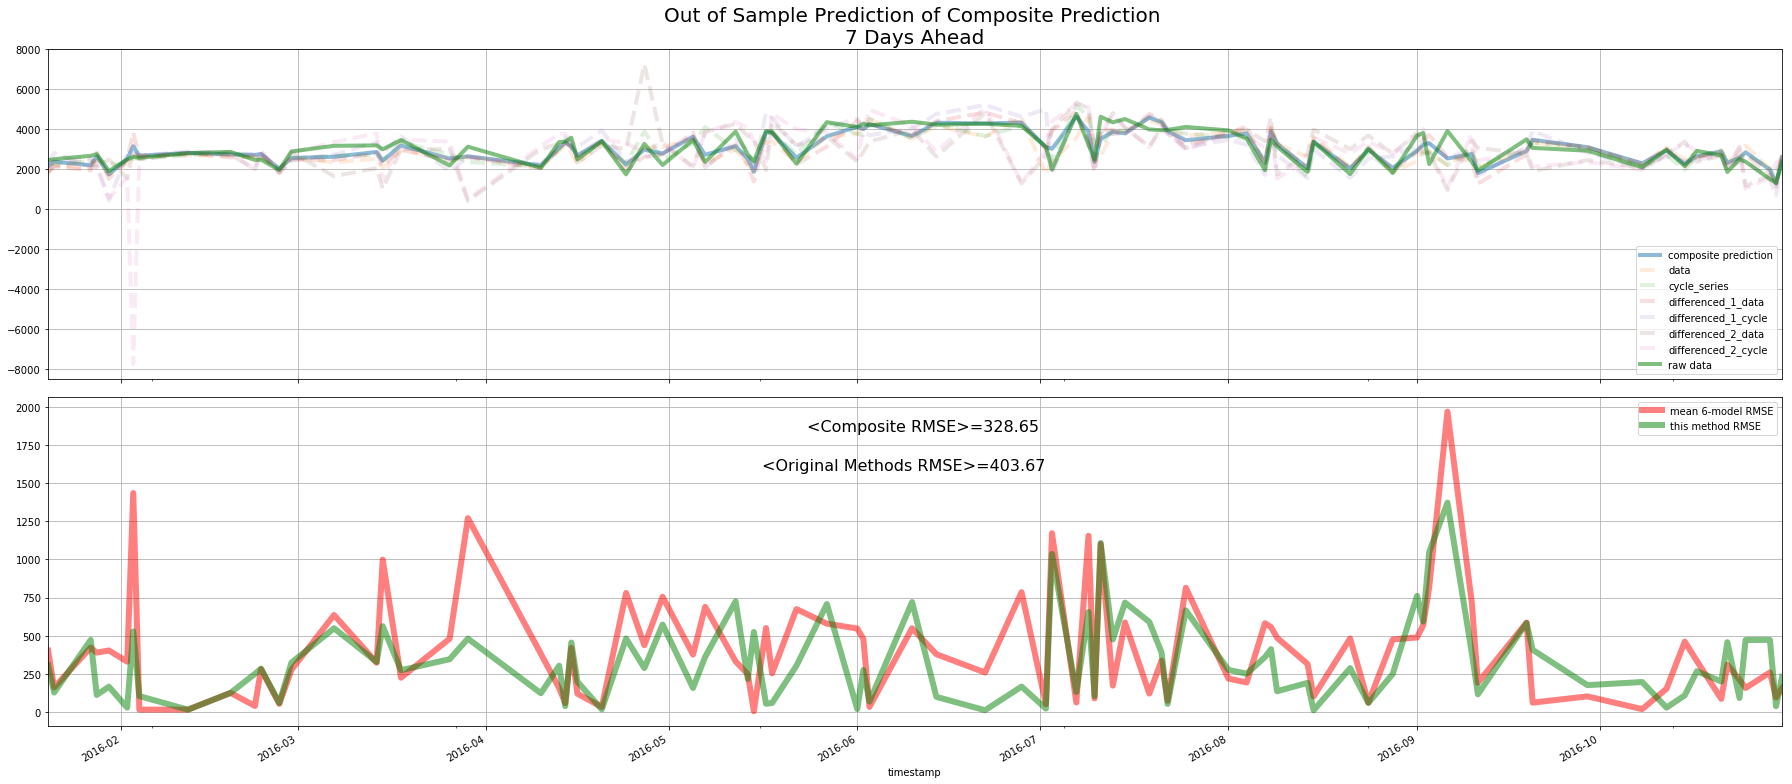

In [26]:
def rmse(actual_series, forecast_series):
    return np.sqrt(((actual_series.sub(forecast_series)) ** 2).mean())


feed_path ='/home/scott/Desktop/CAPSTONE/feeds/feed_'
# "/Users/cclarke/Desktop/Desktop - balle d'argent/ClickFox/Galvanize 2017 Capstone/feed_"
feeds = [x for x in range(10)]
pred_dates = ['p0','p1','p2','p3','p4','p5','p6','p7']#,'p8','p9','p10','p11','p12','p13']
LR_models_dict = {}

this_alpha = 0.5

for feed in feeds:#tqdm(feeds):
    LR_models_dict[feed] = dict()
    for pred in pred_dates:
        plt.close('all')
        #         print('----\nFeed: {} \nPred: {}\n'.format(feed,pred))
        fig = plt.figure(figsize=(12,8))
        X = p_preds_X_dfs_cleaned[feed][pred]
        y = p_preds_y_df_dict[feed]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state =1 )
#       'max_iter', 'beta_2', 'batch_size', 'activation', 'power_t', 'learning_rate_init', 'random_state', 'hidden_layer_sizes', 'early_stopping', 'shuffle', 'validation_fraction', 'learning_rate', 'alpha', 'tol', 'beta_1', 'warm_start', 'epsilon', 'solver', 'nesterovs_momentum', 'verbose', 'momentum'
        model = MLPRegressor(hidden_layer_sizes=(10,10,),early_stopping=False,max_iter=1000, momentum=0.75, shuffle=False, tol=0.01)#LinearRegression() #Lasso(alpha=this_alpha)#
        linear_model = LinearRegression()
#         parameters = {'activation':('tanh', 'tanh', 'relu'), 'learning_rate_init':(.01,.005,.001)}

#         g = GridSearchCV(model, parameters,
#                          cv=5, n_jobs=3, verbose=5)
#         g.fit(X_train, y_train.values.flatten())
#         print(g.best_params_, g.best_score_)
#         grid = GridSearchCV(model,parameters, cv=None)
#         grid.fit(X_train, y_train)
        linear_model.fit(X_train,y_train.values.flatten())
        predictions = linear_model.predict(X_test)
        LR_models_dict[feed][pred] = (y_test,predictions)
        
        results_holder_df = DataFrame(index = X_test.index, columns=['composite prediction'])
        for this_date in X_test.index:
            this_prediction = linear_model.predict(X_test.loc[this_date].values.reshape(-1,6))[0]
            results_holder_df.loc[this_date] = this_prediction
        conversion_dict = {'p0':'This Day','p1':'1 Day Ahead','p2':'2 Days Ahead','p3':'3 Days Ahead','p4':'4 Days Ahead','p5':'5 Days Ahead','p6':'6 Days Ahead','p7':'7 Days Ahead'}
        conversion_dict[pred]
        f = figure(figsize=(25,11)) 
        ax0 = f.add_subplot(211)
        # now that the predictions are in a dataframe, let's plot!
        results_holder_df.plot(lw=4, alpha=0.5, ax=ax0)
        # here's the others (low alpha to not overwhelm the plot)
        X_test.plot(lw=4, alpha=0.15, ax=ax0, ls='--')
        # and the target...
        y_test.columns = ['raw data']
        y_test.plot( lw=4, alpha=0.5, ax=ax0, c='g')
        title('Out of Sample Prediction of Composite Prediction \n' + str(conversion_dict[pred]), fontsize=20)
        plt.grid()
        
        #ylim(0,5555)
        # now the second, RMSE plot
        y_test_t = y_test.T
        X_test_comp = X_test.reindex(y_test.index)
        results_series_reindexed = Series(results_holder_df.values.ravel(), index = y_test.index)
        X_test_mean = X_test_comp.mean(axis=1)
        this_average_rmse = rmse(y_test_t, X_test_mean)
        #composite_rmse = rmse(y_test, results_series_reindexed)
        all_methods_mean_rmse = rmse(y_test_t, X_test_mean)
        composite_rmse = rmse(y_test_t, results_series_reindexed)
        
        ax1 = f.add_subplot(212, sharex=ax0)
        all_methods_mean_rmse.plot(lw=6, alpha=0.5, c='r', label='mean 6-model RMSE', ax=ax1)
        composite_rmse.plot(lw=6, alpha=0.5, c='g', label='this method RMSE',ax=ax1)
        plt.grid()
        legend()
        ax1.annotate('<Composite RMSE>='  + str(round(composite_rmse.mean(),2)), xy=(.45, .45), xycoords='figure fraction', fontsize=16)
        ax1.annotate('<Original Methods RMSE>='  + str(round(all_methods_mean_rmse.mean(),2)), xy=(.425, .4), xycoords='figure fraction',fontsize=16)
        tight_layout()
        #plt.scatter(y_test,predictions)
        #xlim(0,max(y_test.values)[0],max(predictions))
        #ylim(0,max(y_test.values)[0],max(predictions))
        #plt.plot([y_test.min(), y_test.max()],[y_test.min(),y_test.max()], 'k-', alpha = 0.5)
        #plt.title('Test-Prediction Plot -- Feed: {} Pred: {}\nRMSE: {}'.format(feed, pred, mean_squared_error(y_test,predictions)**0.5))

        plt.savefig(feed_path + str(feed) + '_prediction_' + str(pred) + '.png', format='png')
#         plt.legend('Error: {}'.format()
        #plt.close('all')


In [22]:
# here are all the knobs...see if you find even better settings than above....
model.get_params().keys()

dict_keys(['max_iter', 'beta_2', 'batch_size', 'activation', 'power_t', 'learning_rate_init', 'random_state', 'hidden_layer_sizes', 'early_stopping', 'shuffle', 'validation_fraction', 'learning_rate', 'alpha', 'tol', 'beta_1', 'warm_start', 'epsilon', 'solver', 'nesterovs_momentum', 'verbose', 'momentum'])

In [133]:
all_methods_mean_rmse.mean(), composite_rmse.mean()

(565.0392504897118, 553.477391424413)

In [ ]:
rmse()

In [25]:

feeds = [x for x in range(10)]
pred_dates = ['p0','p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13']
for feed in feeds:
    for pred in pred_dates:
        X = p_preds_X_dfs_cleaned[feed][pred]
        y = p_preds_y_df_dict[feed]
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
        linear_model = LinearRegression()
        

        X_train, X_test, y_train, y_test = train_test_split(X, y, 
        test_size=0.3,random_state =1 )
        model = LinearRegression()
        parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
        grid = GridSearchCV(model,parameters, cv=None)
        grid.fit(X_train, y_train)
        print("r2 / variance : ", grid.best_score_)
        print("Residual sum of squares: %.2f"
                  % np.mean((grid.predict(X_test) - y_test) ** 2))

r2 / variance :  0.537089464754
Residual sum of squares: 18913.98
r2 / variance :  0.129366192489
Residual sum of squares: 8899.39
r2 / variance :  0.0497006037248
Residual sum of squares: 9366.95
r2 / variance :  -0.0338251949615
Residual sum of squares: 9852.56
r2 / variance :  -0.0116290576995
Residual sum of squares: 9865.27
r2 / variance :  -0.105854904498
Residual sum of squares: 18135.01
r2 / variance :  0.147075137016
Residual sum of squares: 10265.24
r2 / variance :  0.431670895198
Residual sum of squares: 8596.73
r2 / variance :  0.0829732150918
Residual sum of squares: 11022.09
r2 / variance :  -0.298332709866
Residual sum of squares: 9250.34
r2 / variance :  -0.00994333664308
Residual sum of squares: 10940.67
r2 / variance :  -0.275293267008
Residual sum of squares: 13142.76
r2 / variance :  -0.129921982639
Residual sum of squares: 19594.94
r2 / variance :  0.125630327212
Residual sum of squares: 10169.66
r2 / variance :  0.551586669447
Residual sum of squares: 148243.22
r2

# START: NOTES from 9/26/2017

## Scott, here's one way to generate the error.

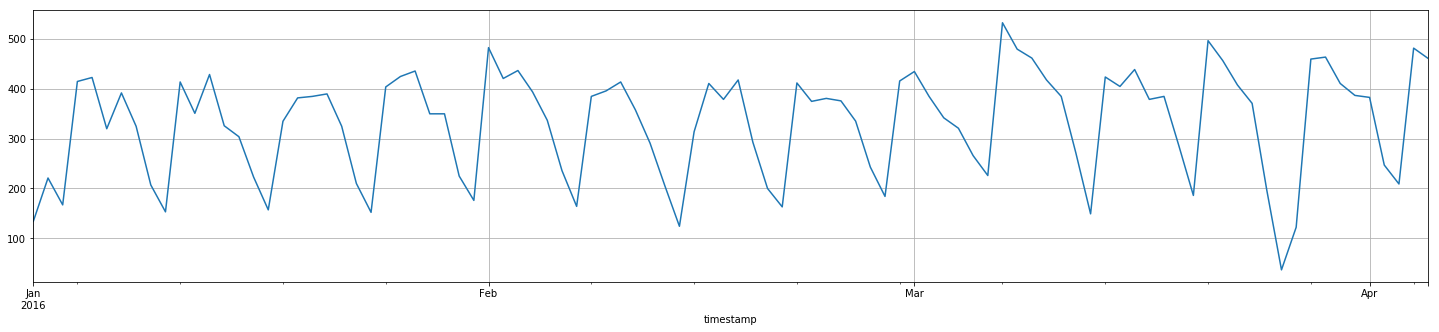

In [21]:
#this_pred.ix["data",datetime(2016,1,1):datetime(2016,4,5), 'this_data'].plot(figsize=(25,5))

# this is how to reference the data in the panels...
this_pred.loc["data",datetime(2016,1,1):datetime(2016,4,5), 'this_data'].plot(figsize=(25,5))
grid()



So, to build error metric, we need to compare:
    the 0th-day value with the p0 forecast
    the 1st-day value with the p1 forecast
    the 2nd-day value with the p2 forecast
    the 3rd-day value with the p3 forecast
    the 4th-day value with the p4 forecast
    the 5th-day value with the p5 forecast
    the 6th-day value with the p6 forecast


    
    

In [18]:
# here's a function which calculates the rmse.  
# it assumes that the series are aligned in time.

def rmse(actual_series, forecast_series):
    return np.sqrt(((actual_series.sub(forecast_series)) ** 2).mean())


In [23]:
# so, here's the raw data that we need to compare to the forecast:
this_pred.loc['data', datetime(2016,4,1): datetime(2016,4,8) , 'this_data']
# we need to generalize this structure depending on how the rest of the function takes shape...

def get_raw_weekly(this_prediction_panel, starting_datetime = datetime(2016, 1,1)):
    """this grabs a week (ok, 8 days worth of RAW data).
    Needs to be supplied the panel containing the information and 
    needs know the starting datetime index.
    remember, all raw data objects are the same, so just grabbing from 'data'.
    """
    # create a datetime index delta object to supply to the new index:
    #dt_delta = date_range()
    new_datetime_index = date_range(starting_datetime, starting_datetime + timedelta(days=7), freq='1d')
    raw_data = this_prediction_panel.loc['data', new_datetime_index, 'this_data']
    return raw_data

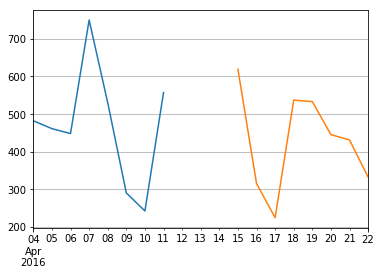

In [24]:
# testing...passed.
get_raw_weekly(this_pred, datetime(2016,4,4)).plot()
get_raw_weekly(this_pred,  datetime(2016,4,15)).plot()
grid()

In [25]:
# now we need to be able to reference the predictions and properly align them to this raw data.
# let's start with looking at a df from the panel..
this_pred.loc['cycle_series', datetime(2016,4,4):datetime(2016,4,8), 'this_data':'p7']

,this_data,p0,p1,p2,p3,p4,p5,p6,p7
timestamp,,,,,,,,,
2016-04-04,482.0,426.802839,417.827803,408.364646,382.633717,388.390453,279.068621,233.352921,389.031916
2016-04-05,461.0,440.361294,352.259004,349.585042,363.000813,225.044152,203.859372,446.547811,419.668915
2016-04-06,448.0,397.985467,384.760118,374.624887,285.400732,237.281038,394.396779,444.960119,402.564532
2016-04-07,750.0,395.470718,351.028533,259.601114,244.158434,394.523888,441.372953,429.232568,395.811599
2016-04-08,530.0,765.217328,356.760980,292.228006,492.497463,410.070698,415.222404,779.729172,837.286156


In [26]:
# so, the raw from the 0th day needs to compared to the p0 prediction here...
# (also remember we need a function that will do this for other prediction models...)
# if we look at the values across the columns, we see that they're already in the order we need...they just so happen
# to be associated with the wrong timeseries index.  (all forecasts for the 4th of april are on that same day.)
# so, all we have to do is grab all 8 predictions and then REINDEX the data.

def get_weekly_forecast_data(this_prediction_panel, this_tab = 'data', starting_datetime = datetime(2016, 1,1)):
    """
    
    """
    wrong_indexed_forecast_data = this_prediction_panel.loc[this_tab, starting_datetime, 'p0':'p7']
    # and now create the new index...
    new_datetime_index = date_range(starting_datetime, starting_datetime+timedelta(days=7), freq='1d')
    # and now change the index to match the data from the raw...
    correctly_indexed_forecast_data_df = DataFrame(wrong_indexed_forecast_data).set_index(new_datetime_index)
    # rename according to source
    correctly_indexed_forecast_data_df.columns = [this_tab]
    # should return a series for comparison
    correctly_indexed_forecast_data_series = correctly_indexed_forecast_data_df[this_tab]
    
    return correctly_indexed_forecast_data_series

In [27]:
get_weekly_forecast_data(this_pred, 'data', datetime(2016,4,1))

2016-04-01    246.512331
2016-04-02     91.464942
2016-04-03    142.038688
2016-04-04    397.266514
2016-04-05    487.313853
2016-04-06    472.156399
2016-04-07    431.464410
2016-04-08    281.096991
Freq: D, Name: data, dtype: float64

In [28]:
# now all we have to do is feed it into the error function:
this_data_forecast = get_weekly_forecast_data(this_pred, 'data', datetime(2016,4,1))
this_data_raw = get_raw_weekly(this_pred, datetime(2016,4,4))

# so this is the RMSE for the next 7 days (including today's as well...)

rmse(this_data_raw, this_data_forecast)

185.40406914492328

# but, we also need to store these values as we iterate through the whole set(s), right?...check this out.


In [29]:
# this following assumes it knows of the index of any panel...(it should have been loaded by now)

In [30]:
this_pred.major_axis

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2016-10-22', '2016-10-23', '2016-10-24', '2016-10-25',
               '2016-10-26', '2016-10-27', '2016-10-28', '2016-10-29',
               '2016-10-30', '2016-10-31'],
              dtype='datetime64[ns]', name='timestamp', length=305, freq=None)

In [31]:
# we can iterate through these object thusly:

def get_weekly_error_for_all_days(this_prediction_panel):
    # create a blank holder for the error results...done for ONE FEED (depending on which panel you give it...)
    # we're setting this up based on info from previous panels...but this is a dataframe.
    this_error_df = DataFrame(index = this_pred.major_axis, columns = this_pred.items)
    
    # now iterate through all tabs of panels and then the timeseries indices...
    for this_tab in this_prediction_panel.items:
        #print(this_tab)
        for this_date in this_prediction_panel.major_axis:
            # get the needed feeds:
            this_data_forecast = get_weekly_forecast_data(this_prediction_panel, this_tab, this_date)
            this_data_raw = get_raw_weekly(this_prediction_panel, this_date) # all the same
            # now assign this error to this tab's column for this day (pretty cool method)
            this_error_df.loc[this_date][this_tab] = rmse(this_data_raw, this_data_forecast)
            #print('\t' + str(rmse(this_data_raw, this_data_forecast)))
    return this_error_df


In [32]:
get_weekly_error_for_all_days(this_pred)

,data,cycle_series,differenced_1_data,differenced_1_cycle,differenced_2_data,differenced_2_cycle
timestamp,,,,,,
2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-07,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-08,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-09,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# now from here, we need to identify the best prediction (idxmin to the rescue!)


In [34]:
get_weekly_error_for_all_days(this_pred).idxmin(axis=1) #for the chosen model create and array that leaves a 1 in the index of the model that was chosen ([0,1,0,0,0,0,0,])

timestamp
2016-01-01                    NaN
2016-01-02                    NaN
2016-01-03                    NaN
2016-01-04                    NaN
2016-01-05                    NaN
2016-01-06                    NaN
2016-01-07                    NaN
2016-01-08                    NaN
2016-01-09                    NaN
2016-01-10                    NaN
2016-01-11                    NaN
2016-01-12                    NaN
2016-01-13                    NaN
2016-01-14                    NaN
2016-01-15                    NaN
2016-01-16           cycle_series
2016-01-17           cycle_series
2016-01-18                   data
2016-01-19           cycle_series
2016-01-20           cycle_series
2016-01-21    differenced_1_cycle
2016-01-22           cycle_series
2016-01-23           cycle_series
2016-01-24    differenced_1_cycle
2016-01-25           cycle_series
2016-01-26    differenced_1_cycle
2016-01-27    differenced_1_cycle
2016-01-28    differenced_1_cycle
2016-01-29    differenced_1_cycle
2016

In [35]:
# would be nice to see which model (for this feed) produced the best (8-day) forecast:
best_methods_for_this_feed = get_weekly_error_for_all_days(this_pred).idxmin(axis=1)


In [36]:
from collections import Counter
Counter(best_methods_for_this_feed.dropna())

Counter({'cycle_series': 74,
         'data': 55,
         'differenced_1_cycle': 76,
         'differenced_1_data': 81,
         'differenced_2_cycle': 1,
         'differenced_2_data': 3})

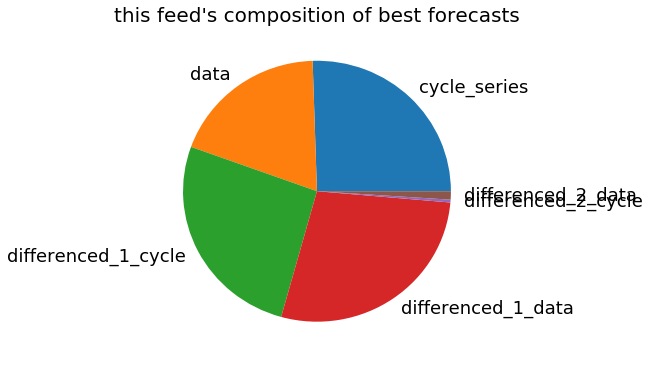

In [37]:
DataFrame.from_dict(Counter(best_methods_for_this_feed.dropna()), orient='index').plot(kind='pie', subplots=True, figsize=(6,6),legend=False, fontsize=18)
ylabel('')
title("this feed's composition of best forecasts", fontsize=20)

# END NOTES from 9/26/2017

In [38]:
def bias_generator(results_df, forecast_term):
    shift_term = int(forecast_term[1:])
    this_forecast_bias = forecast_bias(results_df['this_data'], results_df[forecast_term].shift(shift_term) )
    return this_forecast_bias

def forecast_bias(actual_series, forecast_series):
    """
    fc_bias given by ((actual-forecast)/actual)*100
    """
    forecast_bias_series = (actual_series.sub(forecast_series)).div(actual_series)*100
    return forecast_bias_series

def rmse(actual_series, forecast_series):
    return np.sqrt(((actual_series.sub(forecast_series)) ** 2).mean())



In [39]:
bias_generator(this_pred.loc['data',datetime(2016,4,1):datetime(2016,4,7), :], 'p1')

timestamp
2016-04-01          NaN
2016-04-02    62.969659
2016-04-03    28.900020
2016-04-04    21.849223
2016-04-05    19.727502
2016-04-06    26.781655
2016-04-07    66.352195
dtype: float64

In [40]:
this_pred.loc["data",:, 'this_data'].values


array([ 134.        ,  221.        ,  167.        ,  415.        ,
        423.        ,  320.        ,  392.        ,  325.        ,
        207.        ,  153.        ,  414.        ,  351.        ,
        429.        ,  326.        ,  304.        ,  223.        ,
        157.        ,  335.        ,  382.        ,  385.        ,
        390.        ,  325.        ,  210.        ,  152.        ,
        404.        ,  425.        ,  436.        ,  350.        ,
        350.        ,  225.        ,  176.        ,  483.        ,
        421.        ,  437.        ,  394.        ,  337.        ,
        236.        ,  164.        ,  385.        ,  396.        ,
        414.        ,  358.        ,  291.        ,  206.        ,
        124.        ,  314.        ,  411.        ,  379.        ,
        418.        ,  293.        ,  200.        ,  163.        ,
        412.        ,  375.        ,  381.        ,  376.        ,
        335.29602198,  243.        ,  184.        ,  416.     

In [41]:
def pickles_puller(source_id):
    """
    given the source_id int, this loads and returns the 
    prediction and provenance results stored on the fs in
    the hard-coded path, also hardcoded are the batch params:
    (t_60_f_14).
    
    needs alerts_df.columns for mapping...global scope for now.
    """
    try:
        this_prediction_panel = read_pickle(prediction_path + alerts_df.columns[source_id] + '_t_60_f_14_forecast.pickle')
        this_provenance_panel = read_pickle(prediction_path + alerts_df.columns[source_id] + '_t_60_f_14_provenance.pickle')
    except IOError as ioe:
        print('"' + alerts_df.columns[source_id] + '" not found.')
        return Panel(data=None), Panel(data=None)
    
    return this_prediction_panel, this_provenance_panel

In [42]:
this_pred, this_prov = pickles_puller(0)


NameError: name 'prediction_path' is not defined

In [ ]:
this_pred.loc["data", :, :].head(55)

In [ ]:
this_pred.loc["data", :, "this_data"].plot(figsize=(35,5))
this_pred.loc["data", :, "p14"].shift(14).plot(figsize=(35,5))
grid()

In [ ]:
this_pred.loc["data", :, "this_data"].plot(figsize=(35,5))
#this_pred.ix["data", :, "p14"].shift(14).plot(figsize=(35,5))

In [ ]:
# for my work, i was pulling them simultaneously:

this_pred, this_prov = pickles_puller('0')

In [ ]:
this_prov[0]

In [ ]:
for this_index in this_provenance_results_df.index[111:112]:
    print(this_index)
    print(this_prov.loc[:, this_index, 'h_exp_input_data'])#.abs().idxmin()
    print('\n')
    print(this_provenance_results_df.loc[this_index]['input_source'])

In [ ]:
(this_prov.loc[:, this_index, 'h_exp_input_data']<0) & (this_prov.ix[:, this_index, 'h_exp_input_data'])#.abs().idxmin()) #.abs().sort_values()

In [ ]:
#...continue this toward an adf_score...something to compare the winning forecast to the rest...see how selective it is.:
    
def nomination_uber_score(this_col_int, this_index, adf_var, rmse_var, swp_var, slip_var, he_var, bias_var):
    """
    using augmented Dickey-Fuller test as a high confidence measure, this implements 
    selection based on this...first sorts on strict implementation of adf and picks highest 
    scoring method.
    
    returns the winner and total remaining set.
    """
    # pre-req. is panel prov. data:
    this_pred, this_prov = pickles_puller(this_col_int)
    
    # winning method stats all assembled in this df:
    this_column_name = alerts_df.columns[this_col_int]
    this_provenance_results_df = read_csv(prediction_path + this_column_name + '_t_' + str(training_length) \
                                          + '_compilation_provenance_diags.csv', index_col = 0, parse_dates=True)
    # narrow down to this day's data:
    this_source_id_index_stat = this_provenance_results_df.loc[this_index]
    
    # must first identify this method for comparison (exclude from downstream panels, etc.)
    winning_source = this_provenance_results_df.loc[this_index]['input_source']
    if notnull(winning_source):
        # iterate through the items in the panel and assemble info for a score
       
        # first assemble the adf stats
        all_methods_pval_mult = (this_prov.ix[:, this_index, 'adf_p_input_data']<1.05).astype(int)

        methods_below_1 = this_prov.ix[:,this_index,'adf_ts_input_data'] < this_prov.ix[:, this_index,'adf_1%_input_data']
        methods_below_5 = this_prov.ix[:,this_index,'adf_ts_input_data'] < this_prov.ix[:, this_index,'adf_5%_input_data']
        methods_below_10 = this_prov.ix[:,this_index,'adf_ts_input_data'] < this_prov.ix[:, this_index,'adf_10%_input_data']

        final_exceeds_df = DataFrame(methods_below_1, columns=['exceeds_1']).\
                                 join(DataFrame(methods_below_5, columns=['exceeds_5']).\
                                 join(DataFrame(methods_below_10, columns=['exceeds_10']))).astype(int).sum(axis=1)

        high_confidence_adf_values = final_exceeds_df.mul(all_methods_pval_mult)
        high_confidence_adf_values_max_val = high_confidence_adf_values.max()# needed as idx doesn't deliver >1 in case of tie
        adf_recommends = high_confidence_adf_values[high_confidence_adf_values==high_confidence_adf_values_max_val][:2].index.values.tolist() # was 3
        #print('adf recommends: ' + str(adf_survivors))
        # build best-in-sample ERROR method
        top_2_in_sample = this_prov.ix[:,this_index, 'rms_in_sample_error'].sort_values()[:2].index.values.tolist()  # was 3
        #print('top_3 error:' + str(top_3_in_sample))
        # sw-recommender
        
        sw_p_recommends = this_prov.ix[:, this_index, 'sw_p_input_data'].sort_values()[:2].index.values.tolist() # was 3
        
        #print('sw_p_recommends: '+ str(sw_p_recommends))
        
        slippage_recommends = this_prov.ix[:, this_index, 'n_choice'].sort_values()[:2].index.values.tolist() # was 3
        #print('slippage_recommends: ' + str(slippage_recommends))
        # set logic too restrictive, need voting structure from here on out...
        #combo_index = ['adf_recommended','rms_in_recommended','sw_p_recommended','slippage_recommended']
        #scores_df = DataFrame.from_dict(Counter(adf_survivors + top_3_in_sample + sw_p_recommends + slippage_recommends), orient='index')
        HE_recommends = this_prov.ix[:, this_index, 'h_exp_input_data'].abs().sort_values()[:2].index.values.tolist() # was 4  # top two pairs share top two answers...
        # print('HE recommends')
        bias_recommends = this_prov.ix[:, this_index, 'mean_in_sample_bias'].abs().sort_values()[:2].index.values.tolist()
        
        
        scores_df = DataFrame.from_dict(Counter(adf_var*adf_recommends + rmse_var*top_2_in_sample + swp_var*sw_p_recommends + \
                                                slip_var*slippage_recommends + he_var*HE_recommends + bias_var*bias_recommends), orient='index')
        #print(scores_df)
        # return all methods with highest score (multiple only if tie)
        recommendation = scores_df[scores_df == scores_df.max().values].dropna().index.values
        #adf_error_sw_p_slippage_combo = set(adf_survivors.values.tolist()) & set(top_3_in_sample.values.tolist()) & set(sw_p_recommends.values.tolist()) & set(slippage_recommends.values.tolist())
        #print('final recommendation: ' +  str(adf_error_sw_p_slippage_combo)) 
        
        
        return winning_source, recommendation
    else:
        return np.NaN, np.NaN

In [ ]:
training_length = 60
this_col_int = 1
this_index = alerts_df.index[144]
this_column_name = alerts_df.columns[this_col_int]

this_pred, this_prov = pickles_puller(this_col_int)
this_provenance_results_df = read_csv(prediction_path + this_column_name + '_t_' + str(training_length) \
                                          + '_compilation_provenance_diags.csv', index_col = 0, parse_dates=True)

winning_source = this_provenance_results_df.loc[this_index]['input_source']


print(this_prov.ix[:, this_index, 'n_choice'].dropna())
print('\n best method: ' + str(winning_source))

# basic plotting

In [ ]:
this_pred.ix[:, this_index, 1:].set_index(future_data.index).plot(figsize=(25,5), grid=True)

# this is a sample app of the methods with some plotting thrown in.

In [ ]:
select_path = '/Users/cclarke/hg_reps/sandbox_clarke/Alerting/predictions/decomposition/selection optimization/figures/'
forecast_length=14
golden_thimble = [27, 4, 95, 2, 92, 9, 6, 28, 93, 97]
this_col_int = 0
training_length = 60
len_golden_thimble = len(golden_thimble)
time_set = alerts_df.index[15:285]
len_time_set = len(time_set)

winn_sug_holder_df = DataFrame(index=range(len_time_set*len_golden_thimble), columns=['winner', 'sugg_1' , 'sugg_2', 'sugg_3', 'sugg_4', 'sugg_5', 'sugg_6'])
fake_int = 0
for this_col_int in golden_thimble:
    fake_int+=1
    #this_index = alerts_df.index[55]
    suggested_len_holder = []
    for this_index in time_set:
        #fake_int+=1
        this_pred, this_prov = pickles_puller(this_col_int)
        winner, suggested = nomination_uber_score(this_col_int, this_index, 2,1,0,2,4,3)#,1,1,1,1,4)  #, 0, 0, 0, 0, 6)
        winner_forecast = this_pred.loc[winner, this_index, 1:]
        suggested_forecast = this_pred.loc[suggested[0], this_index, 1:]
        least_rmse_choice = this_prov.loc[:,this_index,'rms_in_sample_error'].idxmin()
        least_error_forecast = this_pred.loc[least_rmse_choice, this_index, 1:]
        future_data_df = alerts_df[alerts_df.columns[this_col_int]].loc[this_index:this_index+relativedelta(days=+forecast_length)]
        past_data_df = alerts_df[alerts_df.columns[this_col_int]].loc[this_index+relativedelta(days=-7):this_index]
        winner_forecast_df = DataFrame(winner_forecast).set_index(future_data_df.index)
        suggested_forecast_df = DataFrame(suggested_forecast).set_index(future_data_df.index)
        least_error_forecast_df = DataFrame(least_error_forecast).set_index(future_data_df.index)
        
        #print(DataFrame(winner_forecast).set_index(future_data.index))
        #winn_sug_holder_df.iloc[fake_int] = pad_stack(winner, suggested, 7)

        f=figure(figsize=(25,5))
        ax0=f.add_subplot(111)
        winner_forecast_df.columns=['best forecast (' + winner + ')']
        suggested_forecast_df.columns=['suggested forecast (' + suggested[0] +')']
        future_data_df.columns=['future data']
        least_error_forecast_df.columns=['least error (' + least_rmse_choice + ')']
        
        future_data_df.plot(figsize=(20,7), ax=ax0, label='future data', lw=4, alpha=0.5, c='k', ls='--')
        winner_forecast_df.plot(ax=ax0, label= 'best forecast', lw=4, alpha=0.5, c='g')
        suggested_forecast_df.plot(lw=4, alpha=0.5, ax=ax0, c='orange')
        least_error_forecast_df.plot(lw=6, alpha=0.35, ax=ax0, c='r')
        past_data_df.plot(lw=4, alpha=0.5, c='k', ls='--')
        grid()
        title('Forecast selection comparisons: \n' + alerts_df.columns[this_col_int] , fontsize=20)
        legend(loc='best')
        #len_series = Series(suggested_len_holder).dropna()    
        #hist(len_series)  
        #clean_win_df = winn_sug_holder_df[notnull(winn_sug_holder_df['winner'])] #.dropna()
        #clean_win_df
        plt.tight_layout()
        #f.savefig(select_path + 'forecast_selection_comp_' + alerts_df.columns[this_col_int] + '_' + str(this_index)[:10] + '.png')
        pylab.close(f)
        clf()
        cla()
        close('all')

In [ ]:
clean_win_df.groupby('winner').describe()

# this iterates through the full subset and returns the counts of the winners, losers and global odds of selecting a winner.

# how many times does this recommend NO method?  that's a job for testing.


In [ ]:
golden_thimble = [27, 4, 95, 2, 92, 9, 6, 28, 93, 97]
training_length = 60
print('start: ' + str(datetime.now().strftime('%b %d, %Y: %H:%M')))

this_source_id_holder_df = DataFrame(index=range(105), columns=['winners','losers', 'overall_win_odds'])
for this_col_int in golden_thimble:#range(105): #brass_bucket:#golden_bucket:#range(105):
    try:
        win_count=lose_count=0
        set_odds_holder = []
        for this_index in  alerts_df.index[37:67]:
            winner, selected = nomination_uber_score(this_col_int, this_index,0,0,0,0,0,4)
            if notnull(winner):
                set_len = len(selected)
                if winner in selected:
                    win_count +=1
                    #print('DING')
                    these_odds = 1/set_len
                else:
                    #print('DONG')
                    lose_count+=1
                    these_odds = 0
                if len(selected) ==0:
                    print('fired a blank!')
            set_odds_holder.append(these_odds)
        this_source_id_df = DataFrame(index=[this_col_int],data=[[win_count, lose_count, mean(set_odds_holder)]], columns=['winners','losers', 'overall_win_odds']) 
        this_source_id_holder_df.loc[this_col_int] = this_source_id_df.values
    except Exception as wtfe:
        print(wtfe)
        pass
str('end: ' + str(datetime.now()))#.strftime('%b %d, %Y: %H:%M'))    

In [ ]:
len(alerts_df.index[37:65])
[1,1,2,3,4]*0

# this performs the optimization

## single shot for testing

In [ ]:
adf_var = rmse_var = swp_var = slip_var = he_var = bias_var = 1
nomination_uber_score(this_col_int, this_index, adf_var, rmse_var, swp_var, slip_var, he_var, bias_var)

In [ ]:
select_path

In [ ]:
def joblib_loop():
    """
    defines parallel job over the highest-level iterator.  
    beneath this level, all others are stepped through
    --handled by Parallel function by mapping.
    """
    sequence = list(range(0,5)) # usually (50,105)
    # 5 is the limit here
    Parallel(n_jobs=5)(delayed(parallel_sweep)(i) for i in sequence) 

# call it

In [ ]:
joblib_loop()

In [ ]:
figure(figsize=(25,5))
plot(sort(global_holder_df['mean_overall_win_odds']), lw=4, alpha=0.5, label='mean success odds')
plot(sort(global_holder_df['std_overall_win_odds']), lw=4, alpha=0.5, label='std() of success odds')

plot(sort(global_holder_df['max_overall_win_odds']), lw=4, alpha=0.5, label='max() of success odds of combination')

grid()
legend(loc='best')
title('independently sorted results from brute force optimization \n golden thimble set (more selective promoters)', fontsize=20)

In [ ]:
clean_outcomes_df

In [ ]:
this_loc_str = global_holder_df['max_overall_win_odds'].idxmax()
adf_var = this_loc_str[0]
rmse_var = this_loc_str[2]
swp_var = this_loc_str[4]
slip_var = this_loc_str[6]
he_var = this_loc_str[8]
bias_var = this_loc_str[10]

this_input_str = 'adf_' + str(adf_var) + '_rmse_' + str(rmse_var) + '_swp_' + str(swp_var) + '_slip_' + str(slip_var) + '_he_' + str(he_var) + '_bias_' + str(bias_var)

this_source_id_holder_df = read_csv(select_path + 'selection_golden_thimble_' + this_input_str + '.csv', index_col = 0)
clean_outcomes_df = this_source_id_holder_df.dropna().copy()
clean_outcomes_df['win_ratio'] = clean_outcomes_df['winners'].div(clean_outcomes_df['losers'].add(clean_outcomes_df['winners']))
#clean_outcomes_df['win_ratio'].plot()
clean_outcomes_df
figure(figsize=(10,6))
plot(clean_outcomes_df.sort_values(by='overall_win_odds')['overall_win_odds'].values, lw=4, alpha=0.5, c='r')
title('Overall odds of picking optimal forecast method \n Golden Thimble ensemble', fontsize=18) #  \n Golden Bucket ensemble
grid()
#ylim(0,.5)

In [ ]:
this_pred, this_prov = pickles_puller(this_col_int)
this_prov.loc['cycle_series', this_index, :]
#this_prov.ix[:, this_index, 'sw_p_input_data']


In [ ]:
singles_list = []
iterable_list_of_singletons = gb_stats_df[gb_stats_df['suggestions_len']==1]['winning_method']
for diz_source in iterable_list_of_singletons:
    singles_list.append(diz_source[0])
    

DataFrame.from_dict(Counter(singles_list), orient='index').plot(kind='pie', subplots=True, figsize=(6,6),legend=False, fontsize=18)
ylabel('')
title('Golden Thimble Ensemble \n Composition of "chosen one" category', fontsize=20)

In [ ]:
singles_list = []
iterable_list_of_singletons = gb_stats_df['winning_method']
#for diz_source in iterable_list_of_singletons:
#    singles_list.append(diz_source)
    

DataFrame.from_dict(Counter(gb_stats_df['best_method']), orient='index').plot(kind='pie', subplots=True, figsize=(6,6),legend=False, fontsize=18)
ylabel('')
title('Golden Thimble Ensemble \n Composition of best method category', fontsize=20)

In [ ]:
from collections import Counter

In [ ]:
loser_len = len(combo_win_lose_df['losers'].dropna())
winner_len = len(combo_win_lose_df['winners'].dropna())
total_len = loser_len + winner_len
winner_pct = winner_len/total_len
loser_pct = loser_len/total_len


f=figure(figsize=(20,10))

ax0=f.add_subplot(121)

DataFrame.from_dict(Counter(combo_win_lose_df['winners'].dropna()), orient='index').plot(kind='pie', subplots=True, figsize=(6,6),legend=False, fontsize=18, ax=ax0)
#title('winners', fontsize=20)
ylabel('')
xlabel('Success (' + str(round(winner_pct*100,2)) + '%)', fontsize=20)
ax1=f.add_subplot(122)

DataFrame.from_dict(Counter(combo_win_lose_df['losers'].dropna()), orient='index').plot(kind='pie', subplots=True, figsize=(6,6),legend=False, fontsize=18, ax=ax1)
xlabel('Failure (' + str(round(loser_pct*100,2)) + '%)', fontsize=20)
ylabel('')
plt.tight_layout()
f.suptitle('Post Smart Selection Method \n(# in Surviving Set)', fontsize=20)

In [ ]:
# example of function to filter the data...might not be considered cheating to NOT always supply 6 models...right?

def adf_underoos_df(provenance_panel, this_item):
    """
    for a given panel and input source (this_item) this version does eval
    across all times for given item and indicates the highest confidence 
    interval breached...along with lower levels.  
    behaves well under nans (returns 0s).
    
    returns a df indexed by timestamp and columned by 
    [exceeds_1, exceeds_5, exceeds_10]
    """
    this_adf_exceeds_1 =  provenance_panel.loc[this_item,:,'adf_ts_input_data'] < provenance_panel.loc[this_item,:,'adf_1%_input_data']
    this_adf_exceeds_5 =  provenance_panel.loc[this_item,:,'adf_ts_input_data'] < provenance_panel.loc[this_item,:,'adf_5%_input_data']  
    this_adf_exceeds_10 = provenance_panel.loc[this_item,:,'adf_ts_input_data'] < provenance_panel.loc[this_item,:,'adf_10%_input_data'] 

    # assemble.  must type at the end to get it to stick after joining
    final_exceeds_df = DataFrame(this_adf_exceeds_1, columns=['exceeds_1']).\
                         join(DataFrame(this_adf_exceeds_5, columns=['exceeds_5']).\
                         join(DataFrame(this_adf_exceeds_10, columns=['exceeds_10']))).astype(int)
    
    return final_exceeds_df

In [ ]:
# which h_exp_input_data is closest to zero??? must get from full prov pickle...

this_h_choice = this_prov.loc[:, this_index, 'h_exp_input_data'].abs().idxmin()
sum(h_choice_holder)/(305-14)

h_choices_df = DataFrame(index = this_provenance_results_df.index, data = h_choice_holder, columns=['best_hurst'])
h_choices_df.iloc[49]
this_provenance_results_df.iloc[49]

# example methods to determine best prediction (should only be used for historical values!)

In [ ]:
def forecast_bias(actual_series, forecast_series):
    """
    fc_bias given by ((actual-forecast)/actual)*100
    """
    forecast_bias_series = (actual_series.sub(forecast_series)).div(actual_series)*100
    return forecast_bias_series


def mean_weekly_biases_df(this_pred_panel, this_panel_item):
    """
    given this_pred_panel, and item, this returns a df
    indexed by prediction panel's major index (timeseries), columned by 
    ['mean_out_sample_1w_bias','mean_out_sample_2w_bias']
    """
    # start with this slice
    this_item_df = this_pred_panel.loc[this_panel_item,:,:]
    # identify index to run through, needs gating (14+1 from the back)
    this_time_index = this_item_df.index[:-15]
    
    # need to hold the intermediate values and assign to holder_df:
    holder_cols = ['mean_out_sample_1w_bias','mean_out_sample_2w_bias']
    per_index_biases_holder_df = DataFrame(index=this_time_index, columns = holder_cols)
    
    # this needs to loop through the index to assemble the biases as the indices are orthogonal
    for this_date in this_time_index:
        # reference the index to which we will write
        this_spans_tomorrow = this_date + relativedelta(days=1) # convert to ts, universal value
        # reset the intermediate mean_out_sample_xw_bias variable df
        mean_out_sample_xw_bias = DataFrame(columns=[7,14])
        # iterate through the 2 periods for biases (1 week, 2 weeks)
        
        for this_bias_length in [7,14]: # could float this up, but don't...
            column_names = this_item_df.columns[2 : this_bias_length + 2]
            #print(str(this_date) + '\n')
            #for this_bias_length in [7, 14]:
            this_spans_rd = relativedelta(days=(this_bias_length-1)) # give up to p7|p14
            # identify the data we're biasing off of.
            this_df_data = this_item_df[this_spans_tomorrow: this_spans_tomorrow + this_spans_rd]['this_data'].values
            #this_df_data_T_values = this_df
            # plus one to remove today's prediction, but still need the the result indexed by today...
            this_days_future_df = DataFrame(index=[this_date], data=[this_df_data], columns=column_names).T 
            # now with the future determined, let's look up the forecast:
            
            this_days_forecast_df = DataFrame(this_item_df.loc[this_date][column_names])
            this_w_ave_bias = forecast_bias(this_days_future_df, this_days_forecast_df).mean()
            this_w_ave_bias_df = DataFrame(data=this_w_ave_bias, columns=[this_bias_length])
            
            mean_out_sample_xw_bias[this_bias_length] = this_w_ave_bias
        #print(mean_out_sample_xw_bias)
        mean_out_sample_xw_bias.columns=holder_cols
            #this_index_biases_df = mean_out_sample_xw_bias.join(mean_out_sample_2w_bias) 
        per_index_biases_holder_df.loc[this_date] = mean_out_sample_xw_bias.values#this_index_biases_df.values
        
    return per_index_biases_holder_df
 


def adf_underoos(provenance_panel, day_int):
    """
    for a given panel and day_int (integer tracking the day of the series), 
    this indicates the highest confidence interval breached...along with 
    lower levels.  behaves well under nans (returns 0s).
    
    returns a df indexed by inut feed, and columned by 
    [exceeds_1, exceeds_5, exceeds_10]
    """
    this_adf_exceeds_1 =  provenance_panel.ix[:,day_int,'adf_ts_input_data'] < provenance_panel.ix[:,day_int,'adf_1%_input_data']
    this_adf_exceeds_5 =  provenance_panel.ix[:,day_int,'adf_ts_input_data'] < provenance_panel.ix[:,day_int,'adf_5%_input_data']  
    this_adf_exceeds_10 = provenance_panel.ix[:,day_int,'adf_ts_input_data'] < provenance_panel.ix[:,day_int,'adf_10%_input_data'] 

    # assemble.  must type at the end to get it to stick after joining
    final_exceeds_df = DataFrame(this_adf_exceeds_1, columns=['exceeds_1']).\
                         join(DataFrame(this_adf_exceeds_5, columns=['exceeds_5']).\
                         join(DataFrame(this_adf_exceeds_10, columns=['exceeds_10']))).astype(int)
    
    return final_exceeds_df
        
def adf_underoos_df(provenance_panel, this_item):
    """
    for a given panel and input source (this_item) this version does eval
    across all times for given item and indicates the highest confidence 
    interval breached...along with lower levels.  
    behaves well under nans (returns 0s).
    
    returns a df indexed by timestamp and columned by 
    [exceeds_1, exceeds_5, exceeds_10]
    """
    this_adf_exceeds_1 =  provenance_panel.ix[this_item,:,'adf_ts_input_data'] < provenance_panel.ix[this_item,:,'adf_1%_input_data']
    this_adf_exceeds_5 =  provenance_panel.ix[this_item,:,'adf_ts_input_data'] < provenance_panel.ix[this_item,:,'adf_5%_input_data']  
    this_adf_exceeds_10 = provenance_panel.ix[this_item,:,'adf_ts_input_data'] < provenance_panel.ix[this_item,:,'adf_10%_input_data'] 

    # assemble.  must type at the end to get it to stick after joining
    final_exceeds_df = DataFrame(this_adf_exceeds_1, columns=['exceeds_1']).\
                         join(DataFrame(this_adf_exceeds_5, columns=['exceeds_5']).\
                         join(DataFrame(this_adf_exceeds_10, columns=['exceeds_10']))).astype(int)
    
    return final_exceeds_df
    
    
    
def hurst_exponent_ranger(provenance_panel, day_int):
    """
    for a given panel and day_int (integer tracking the day of the series), 
    this indicates the range given by modified hurst exponent calculation, 
    within he_threshold tolerance.  these bands are mutually-exclusive, 
    and he->[-1,1].  behaves well under nans (returns 0s).
    
    returns a df indexed by inut feed, and columned by 
    [he_<_0, he_~_0, he_>_0]
    """
    he_threshold = 0.05
    # comparison to non-df means we must rename resultant df
    this_he_under_0 =  DataFrame(provenance_panel.ix[:,day_int,'h_exp_input_data'] <= (0 - he_threshold))
    this_he_approx_0 =  DataFrame((provenance_panel.ix[:,day_int,'h_exp_input_data'] > (0 - he_threshold)) & \
                        (provenance_panel.ix[:,day_int,'h_exp_input_data'] < (0 + he_threshold)))  
    this_he_over_0 = DataFrame(provenance_panel.ix[:,day_int,'h_exp_input_data'] >= (0 + he_threshold))
    
    # must rename as comparison isn't with like type
    this_he_under_0.columns=['he_<_0']
    this_he_approx_0.columns=['he_~_0']
    this_he_over_0.columns=['he_>_0']
    
    # assemble.  must type at the end to get it to stick after joining. 
    final_range_df = this_he_under_0.append(this_he_approx_0)#.join(this_he_over_0))#.astype(int)
    
    return (this_he_under_0.join(this_he_approx_0).join(this_he_over_0)).astype(int)
       
    
def hurst_exponent_ranger_df(provenance_panel, this_item):
    """
    for a given panel and input feed (this_item), 
    this indicates the range given by modified hurst exponent calculation, 
    within he_threshold tolerance.  these bands are mutually-exclusive, 
    and he->[-1,1].  behaves well under nans (returns 0s).
    
    returns a df indexed by timestamp, and columned by 
    
    [he_<_0, he_~_0, he_>_0]
    """
    he_threshold = 0.05
    # comparison to non-df means we must rename resultant df
    this_he_under_0 =  DataFrame(provenance_panel.ix[this_item,:,'h_exp_input_data'] <= (0 - he_threshold))
    this_he_approx_0 =  DataFrame((provenance_panel.ix[this_item,:,'h_exp_input_data'] > (0 - he_threshold)) & \
                        (provenance_panel.ix[this_item,:,'h_exp_input_data'] < (0 + he_threshold)))  
    this_he_over_0 = DataFrame(provenance_panel.ix[this_item,:,'h_exp_input_data'] >= (0 + he_threshold))
    
    # must rename as comparison isn't with like type
    this_he_under_0.columns=['he_<_0']
    this_he_approx_0.columns=['he_~_0']
    this_he_over_0.columns=['he_>_0']
    
    # assemble.  must type at the end to get it to stick after joining. 
    final_hurst_df = (this_he_under_0.join(this_he_approx_0).join(this_he_over_0)).astype(int)
    
    return final_hurst_df
     
def mean_weekly_errors_df(this_pred_panel, this_panel_item):
    """
    given this_pred_panel, and item, this returns a df
    indexed by prediction panel's major index (timeseries), columned by 
    ['mean_out_sample_1w_bias','mean_out_sample_2w_bias', 'rms_out_sample_1w_error', 'rms_out_sample_2w_error']
    """
    # start with this slice
    this_item_df = this_pred_panel.ix[this_panel_item,:,:]
    # identify index to run through, needs gating (14+1 from the back)
    this_time_index = this_item_df.index[:-15]
    
    # need to hold the intermediate values and assign to holder_df:
    holder_cols = ['mean_out_sample_1w_bias','rms_out_sample_1w_error',\
                   'mean_out_sample_2w_bias','rms_out_sample_2w_error']
    
    per_index_errors_holder_df = DataFrame(index=this_time_index, columns = holder_cols)
    
    # this needs to loop through the index to assemble the biases as the indices are orthogonal
    # truncated above, so run the span here:
    for this_date in this_time_index:
        # reference the index to which we will write
        this_spans_tomorrow = this_date + relativedelta(days=1) # convert to ts, universal value
        # reset the intermediate mean_out_sample_xw_bias variable df
        mean_out_sample_xw_bias = DataFrame(columns=['7_fb', '7_rmse', '14_fb' ,'14_rmse'])
        # iterate through the 2 periods for biases (1 week, 2 weeks)
        
        for this_bias_length in [7,14]: # could float this up, but don't...
            # line up column names to make series math simple and reliable.
            column_names = this_item_df.columns[2 : this_bias_length + 2]
            
            #print(str(this_date) + '\n')
            #for this_bias_length in [7, 14]:
            this_spans_rd = relativedelta(days=(this_bias_length-1)) # give up to p7|p14
            # identify the data we're biasing off of.
            this_df_data = this_item_df[this_spans_tomorrow: this_spans_tomorrow + this_spans_rd]['this_data'].values
            #this_df_data_T_values = this_df
            
            # plus one to remove today's prediction, but still need the the result indexed by today...
            this_days_future_df = DataFrame(index=[this_date], data=[this_df_data], columns=column_names).T 
            # now with the future determined, let's look up the forecast:
            
            this_days_forecast_df = DataFrame(this_item_df.loc[this_date][column_names])
            
            this_w_ave_bias = forecast_bias(this_days_future_df, this_days_forecast_df).mean()
            this_w_ave_bias_df = DataFrame(data=this_w_ave_bias, columns=[str(this_bias_length) + '_fb'])
            this_w_rmse = rmse(this_days_future_df, this_days_forecast_df)
            this_w_rmse_df = DataFrame(data=this_w_rmse, columns=[str(this_bias_length) + '_rmse'])
            this_w_combo = this_w_ave_bias_df.join(this_w_rmse_df)
            
            # iterate here to slot these in: (inherits index...)
            mean_out_sample_xw_bias[[str(this_bias_length) + '_fb', str(this_bias_length) + '_rmse']] = \
                        this_w_combo[[str(this_bias_length) + '_fb', str(this_bias_length) + '_rmse']]#[[this_w_ave_bias], [this_w_rmse]]
 
        per_index_errors_holder_df.loc[this_date] = mean_out_sample_xw_bias.values#.loc[this_date]#[mean_out_sample_xw_bias.values]#this_index_biases_df.values
       
    return per_index_errors_holder_df
    
    


# functionalizing the processing script that takes the best forecasts and strings them together for all source_ids

In [ ]:


def create_bcs_forecasts(source_id_list, pickle_path, this_error_metric='rms_out_sample_1w_error', this_forecast_length=7):
    """
    used to select best forecasts and string them
    together to create new benchmark.  does for either forecast_bias or rmse.
    uses an 'on the fly' error comparer--not relying on preprocessed files.  
    source_id_header = range(105) # these will be the names of the items in the panel
    
    this_error_metric -> {'rms_out_sample_1w_error', 'mean_out_sample_1w_bias'}
    this_forecast_length -> period for which error is being measured, [3, 7,14, etc.]
    pickle_path: read and write to this path.
    
    alerts_df, prediction_path,  needed as globals.
    
    """
    
    # helpers
    def future_forecast_df_col_builder_plus_source(forecast_length):
        """
        with a given integer forecast_length, this returns a 
        familiar index to use to label columns.
        """
        f_list=['this_data']
        for fl in range(0,forecast_length+1):
            f_list.append('p'+str(fl))
        #f_list.append('source')
        return f_list

    def rmse(actual_series, forecast_series):
        """
        given the actual and forecast series, this returns the rmse.

        """
        return np.sqrt(((actual_series.sub(forecast_series)) ** 2).mean())

    
    def pickles_puller(source_id):
        """
        given the source_id int, this loads and returns the 
        prediction and provenance results stored on the fs in
        the hard-coded path, also hardcoded are the batch params:
        (t_60_f_14).

        needs alerts_df.columns for mapping...global scope for now.
        """
        try:
            this_prediction_panel = read_pickle(prediction_path + alerts_df.columns[source_id] + '_t_60_f_14_forecast.pickle')
            this_provenance_panel = read_pickle(prediction_path + alerts_df.columns[source_id] + '_t_60_f_14_provenance.pickle')
        except IOError as ioe:
            print('"' + alerts_df.columns[source_id] + '" not found.')
            return Panel(data=None), Panel(data=None)

        return this_prediction_panel, this_provenance_panel

    
    print('starting run: ' + '\n\t processing ' + str(len(source_id_list)) + ' feeds for ' + \
          str(len(alerts_df.dropna(axis=1).index)-(this_forecast_length+1)) + ' days each.')
    
    run_list = source_id_list #list(range(105))
    
    forecast_output_panel = Panel(data=None, items=run_list, major_axis=alerts_df.index, \
                                  minor_axis=future_forecast_df_col_builder_plus_source(this_forecast_length))

    best_source_panel = Panel(data=None, items=run_list, major_axis=alerts_df.index, \
                                  minor_axis=['best forecast source'])
    
    
    for this_col_int in run_list: # run_list has redacted record 
        try:

            # TODO: add error handling here

            # build the df to hold the results of the best prediction...

            # this structure reads the pre-computed file, add a few options for later into this holder... 
            # this_source_id_winner_holder_df = DataFrame(index=alerts_df.index, columns = ['in_bias_winner', 'in_rmse_winner', 'out_bias_winner', 'out_rmse_winner'])

            # need to load the pickles corresponding to this source_id...
            this_pred, this_prov = pickles_puller(this_col_int)

            # df to hold the placements
            rank_holder_df = DataFrame(index=alerts_df.index, columns = [this_prov.items])
            # generate the errors for 1w, 2w periods.  done by 'item'

            # iterate through this prediction panel to get all forecasts for the 6 methods.
            for this_item in this_pred:
                this_items_errors = mean_weekly_errors_df(this_pred, this_item)
                rank_holder_df[this_item] = this_items_errors[this_error_metric]

            # now find best method for each timestep:
            this_source_id_best_methods = rank_holder_df.T.idxmin() 
            
            #print('starting the forecast lookup...')

            # now step through the index and write the best forecasts and track source
            for this_index in this_source_id_best_methods.index:
                best_forecast_item = this_source_id_best_methods.loc[this_index]
                
                # assign the source to separate panel
                best_source_panel.ix[this_col_int, this_index, 0] = best_forecast_item
                
                # print(best_forecast_item)
                # need conditional for 'warm-up' period so we don't attempt to use nan-indexer:
                if notnull(best_forecast_item):
                    # now pull the forecast for this day from this panel
                    this_best_forecast_series = this_pred.ix[best_forecast_item, this_index, :(this_forecast_length + 2)]

                    # tack on the source of this forecast for posterity
                    #this_best_forecast_series['source'] = best_forecast_item # this mixed dtype is jacking the panel assignment
                    # recast as df for values dimensionality:

                    this_best_forecast_df = DataFrame(this_best_forecast_series)
                    #print(this_best_forecast_df.values)
                    #print(shape(this_best_forecast_df.values))
                    # now assign this to the current sheet of the panel (auto-track the index)
                    forecast_output_panel.ix[this_col_int, this_index, :] = this_best_forecast_series.values#this_best_forecast_df.values
                    
            # panel doesn't like source assignment of mixed dtypes of panel asignment, write this separately.
            rank_holder_df.to_csv(pickle_path + 'best_sources_' + alerts_df.columns[this_col_int] + '_t_60_f_7.csv')
        except Exception as wtfe:
            print(wtfe)
            print('\t\t source_id ' + str(this_col_int) + ' failed.')
            pass
            
        print('\t\t source_id ' + str(this_col_int) + ' done.')
    
    # finally, write to fs
    print('\t serializing outputs: ')
    forecast_output_panel.to_pickle(pickle_path + 'all_best_case_forecasts_' + str(len(source_id_list)) + '_source_ids.pickle')
    forecast_output_panel.to_excel(pickle_path + 'all_best_case_forecasts_' + str(len(source_id_list)) + '_source_ids.xls')
    best_source_panel.to_pickle(pickle_path + 'all_best_case_forecast_sources_' + str(len(source_id_list)) + '_source_ids.pickle')
    best_source_panel.to_excel(pickle_path + 'all_best_case_forecast_sources_' + str(len(source_id_list)) + '_source_ids.xls')
    
    print('done, results saved to ' + pickle_path)
    
    return forecast_output_panel

In [ ]:
# testing
p_path = '/Users/cclarke/hg_reps/sandbox_clarke/Alerting/predictions/decomposition/results/'
this_set = range(105)
tp=create_bcs_forecasts(this_set, pickle_path=p_path, this_error_metric='rms_out_sample_1w_error', this_forecast_length=7)

In [ ]:
from collections import Counter
#Counter(this_source_id_winner_holder_df['1st'])#.dropna().count()
#winner_percent
#Counter()
#counts = Counter(this_source_id_winner_holder_df['out_bias_winner'].dropna())
Counter(this_source_id_winner_holder_df['out_bias_winner'].dropna())
#pyplot.pie(counts, autopct=None)
#this_source_id_winner_holder_df['out_bias_winner']

In [ ]:
from collections import Counter
p_path = '/Users/cclarke/hg_reps/sandbox_clarke/Alerting/predictions/decomposition/results/'
source_id_list = range(105)
# read all best sources
best_source_panel = read_pickle(p_path + 'all_best_case_forecast_sources_' + str(len(source_id_list)) + '_source_ids.pickle')


In [ ]:
from pandas import value_counts

In [ ]:
Counter(best_source_panel.ix[99,:,0].dropna())
this_counter = {'cycle_series': 0,'data': 0,'differenced_1_cycle': 0,'differenced_1_data': 0,'differenced_2_cycle': 0,'differenced_2_data': 0}
this_counter_df = DataFrame.from_dict(Counter(this_counter), orient='index')

In [ ]:
this_source_list = value_counts(best_source_panel.ix[0,:,0])
should_be_here_list = ['cycle_series', 'differenced_1_cycle', 'differenced_1_data', 'data', 'differenced_2_data', 'differenced_2_cycle']

# add a loop to insure index integrity
for should_be in should_be_here_list:
    if should_be not in this_source_list.index:
        series[should_be] = 0
        
this_source_list        

In [ ]:
this_counter.keys()

In [ ]:
this_counter = Counter(best_source_panel.ix[99,:,0].dropna())
#.add(Counter(best_source_panel.ix[0,:,0].dropna()))
DataFrame.from_dict(this_counter, orient='index')
these_best = best_source_panel.ix[:,:,0].dropna()

this_counter = {'cycle_series': 0,'data': 0,'differenced_1_cycle': 0,'differenced_1_data': 0,'differenced_2_cycle': 0,'differenced_2_data': 0}
this_counter_df = DataFrame.from_dict(Counter(this_counter), orient='index')
this_next_counter = DataFrame()
#def this_next_counter_df(col):
#    return this_next_counter_df = DataFrame.from_dict(Counter(best_source_panel.ix[col,:,0].dropna()), orient='index')

# so, if the values don't exist for a method, this index is undefined...work around the counter method.
for col in these_best.columns:
    this_counter_dict = Counter(best_source_panel.ix[col,:,0].dropna())
    # add a loop to insure index integrity
    for should_be in should_be_here_list:
        if should_be not in this_counter_dict.keys():
            this_counter_dict[should_be] = 0
            print('source_id: ' + str(col) + ' is missing: ' + should_be)
    # now complete, cast as df and sum
    this_next_counter_df = DataFrame.from_dict(this_counter_dict, orient='index')
    #print(this_next_counter_df)
    this_counter_df = this_counter_df.add(this_next_counter_df)
    
    
this_counter_df.plot(kind='pie', figsize=(6,6), subplots=True, legend=False, autopct='%.2f', fontsize=14)
title("Best Forecast Sources", fontsize=20)
ylabel('')

In [ ]:
clean_tops_holder_df = tops_holder_df.dropna()#.astype(float).hist()
figure(figsize=(12,8))
clean_tops_holder_df['top_1'].hist(color='r', alpha=0.5, label='top 1 (exact match)')
clean_tops_holder_df['top_2'].hist(color='orange', alpha=0.5, label='matched top 2')
clean_tops_holder_df['top_3'].hist(color='green', alpha=0.5, label='matched top 3')
title('selection based on in/out-sample prediction bias \n top matches percentages', fontsize=18)
legend(loc='upper left')


# misc. column (p, q) [parsing]

In [ ]:
def pq_parser(pq_tuple, pmax=9, qmax=9):
    """
    this extracts the necessary info from the provenance table
    to display the choices in a normalized scale.  apply-able.
    """
    def gen_p_q_dict():
        p_q_dict = {}
        counter_int = 0
        # build up the p_q_dict for mapping
        normalization = len(range(pmax+1))*len(range(qmax+1))
        for p in range(0,pmax+1,1):#range(7,-1,-1):
            for q in range(0,qmax+1,1):#range(7,-1,-1):
                counter_int+=1
                p_q_dict[(p,q)] = counter_int/normalization
        return p_q_dict
    p_q_dict = gen_p_q_dict()

    if isnull(eval(pq_tuple)):
        return [np.NaN]
    else:
        return p_q_dict[eval(pq_tuple)]

    
def pq_parser_simple(pq_tuple):
    """
    simply return the two series...
    """
    if isnull(pq_tuple):
        return [np.NaN, np.NaN]
    else:
        return [int(pq_tuple[1]), int(pq_tuple[3])]
    
def q_parser_simple(pq_tuple):
    """
    simply return the two series...
    """

    if isnull(pq_tuple[3]):
        return np.NaN
    else:
        return int(pq_tuple[3])
       

In [ ]:
each column has this type of name for the predictions...
ft='p13'

i supply that to the function which plots ALL of the 13-day predictions together with the raw data...

like this:

ft[-1] # this was designed to strip the NUMBER off the name to be used.  either come up with another or substitute the following whereever this shit appears.

ft[1:] # <--- this is it.

# main image viz here.

In [ ]:
# rewriting this to accept the newer file strings...skip the panel input option for expediency 

def results_bias_plot_from_pickles(this_col_int, training_length, forecast_term):
    """
    given the column of interest, forecast term (p0, p1, etc.), and path to results set.
    this generates a visualization of the model outputs and bias (with distribution).
    also saves to fs.
    TODO: need to annotate with which training length, how many gaps there are and...
    """

    # helpers
    def sw_tester(series):
        """
        test the df for non-gaussianity (null hyp. rejection, rather)
        see: https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test
        needs: scipy
        """
        sw= scipy.stats.shapiro(series.dropna())[0]
        swp=scipy.stats.shapiro(series.dropna())[1]
        return sw, swp 
    
    # generalized bias function generator
    def bias_generator(results_df, forecast_term):
        shift_term = int(forecast_term[1:])
        this_forecast_bias = forecast_bias(results_df['this_data'], results_df[forecast_term].shift(shift_term) )
        return this_forecast_bias
    
    def forecast_bias(actual_series, forecast_series):
        """
        fc_bias given by ((actual-forecast)/actual)*100
        """
        forecast_bias_series = (actual_series.sub(forecast_series)).div(actual_series)*100
        return forecast_bias_series

    def rmse(actual_series, forecast_series):
        return np.sqrt(((actual_series.sub(forecast_series)) ** 2).mean())


    def pq_parser(first_pq, final_pq):
        """
        this extracts the necessary info from the provenance table
        to display the choices in a normalized scale.  needs to be 
        generalized to accept pmax,qmax
        """
        def gen_p_q_dict():
            p_q_dict = {}
            counter_int = 0
            pmax=9
            qmax=9
            # build up the p_q_dict for mapping
            normalization = len(range(pmax+1))*len(range(qmax+1))
            for p in range(0,pmax+1,1):#range(7,-1,-1):
                for q in range(0,qmax+1,1):#range(7,-1,-1):
                    counter_int+=1
                    p_q_dict[(p,q)] = counter_int/normalization
            return p_q_dict
        p_q_dict = gen_p_q_dict()

        if isnull(first_pq) or isnull(final_pq):
            return [np.NaN,np.NaN]
        else:
            return p_q_dict[first_pq], p_q_dict[final_pq]
        
    def p_or_q_parser(first_pq_or_final_pq):
        """
        this extracts the necessary info from the provenance table
        to display the choices in a normalized scale.  needs to be 
        generalized to accept pmax,qmax
        """
        def gen_p_q_dict():
            p_q_dict = {}
            counter_int = 0
            pmax=9
            qmax=9
            # build up the p_q_dict for mapping
            normalization = len(range(pmax+1))*len(range(qmax+1))
            for p in range(0,pmax+1,1):#range(7,-1,-1):
                for q in range(0,qmax+1,1):#range(7,-1,-1):
                    counter_int+=1
                    p_q_dict[(p,q)] = counter_int/normalization
            return p_q_dict
        p_q_dict = gen_p_q_dict()

        if isnull(first_pq_or_final_pq):
            #print('found nan')
            return np.NaN
        else:
            return p_q_dict[first_pq_or_final_pq]
    
    
    def provenance_parser(provenance_string):
        """
        this extracts the necessary info from the provenance entry.
        what to do for blank?
        """
        def gen_p_q_dict():
            p_q_dict = {}
            counter_int = 0
            pmax=9
            qmax=9
            # build up the p_q_dict for mapping
            normalization = len(range(pmax+1))*len(range(qmax+1))
            for p in range(0,8,1):#range(7,-1,-1):
                for q in range(0,8,1):#range(7,-1,-1):
                    counter_int+=1
                    p_q_dict[(p,q)] = counter_int/normalization
            return p_q_dict
        p_q_dict = gen_p_q_dict()

        if isnull(provenance_string):
            return [np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN]
        else:
            first_pq, final_pq, n_choice, quantile_used, day_0_fb, p_zero, blank_count = map(eval,provenance_string.split("_"))

        return p_q_dict[first_pq], p_q_dict[final_pq], n_choice, quantile_used, day_0_fb, p_zero, blank_count

    def pie_maker(this_bias):

        pie_labels = ['< 5%','5% < 10%','10% < 15%','15% < 20%','> 20%','> 100%']
        y_df = DataFrame(index=['share'], columns = pie_labels)
        y_df = DataFrame(index = ['0'],columns = ['< 5%','5% < 10%','10% < 15%','15% < 20%','> 20%','> 100%'])
        y_df['< 5%'] = this_bias[abs(this_bias)<5].dropna().count()
        y_df['5% < 10%'] = this_bias[(abs(this_bias)>=5) & (abs(this_bias)<=10)].dropna().count()
        y_df['10% < 15%'] = this_bias[(abs(this_bias)>=10) & (abs(this_bias)<=15)].dropna().count()
        y_df['15% < 20%'] = this_bias[(abs(this_bias)>=15) & (abs(this_bias)<=20)].dropna().count()
        y_df['> 20%'] = this_bias[(abs(this_bias)>=25)].dropna().count()
        y_df['> 100%'] = this_bias[abs(this_bias)>100].dropna().count()
        colors = ['green', 'yellowgreen', 'yellow', 'orange', 'red','black']
        plt.axis('equal')
        patches, texts = plt.pie(y_df.values.ravel(), colors=colors, startangle=90)
        legend(patches, pie_labels, loc=[.85,.25])#, title='Forecast Accuracy')
        title('Forecast Accuracy', fontsize=16,y=.925)        
        return patches
    
    # mapping for formatting, etc.
    this_column_name = alerts_df.columns[this_col_int]
    # paths and I/O
    
    # loading the best forecasts pickle:
    best_forecasts_pickle = read_pickle(prediction_path + 'all_best_case_forecasts_105_source_ids.pickle')
    # loading the best sources pickle:
    best_sources_pickle = read_pickle(prediction_path + 'all_best_case_forecast_sources_105_source_ids.pickle')
    
    # new methods here for prov from pickle...
    this_pred, this_prov = pickles_puller(this_col_int)
    
    # look up the best forecasts here (itemed by source_id, majored by ts-index, minored by 'this_data' to 'p7'
    results_df = best_forecasts_pickle.ix[this_col_int,:,:]
   
    # create custom prov_df here from 'best of' sources, start with shell and fill.
    provenance_results_df = DataFrame(index = this_prov.major_axis, columns=this_prov.minor_axis)
    # need to x-ref with sources_df on fs.
    
    # must iterate through sources (by ts-index) to index, pull (agg) this info
    for this_index in this_prov.major_axis: # can't do assignments over nan-index...can't seem to avoid it, either
        this_best_source = best_sources_pickle.ix[this_col_int, this_index, 'best fourcast source'] # [sic]
        if notnull(this_best_source):
            provenance_results_df.loc[this_index] = this_prov.ix[this_best_source, this_index, :]
            # first get source for this forecast...unfortunately kept in separate df on fs:

    # don't forget to write this to fs
    dp_keeper_list = ['training_length', 'first_pq','final_pq', 'n_choice', 'p_zero', 'blank_count']
    parsed_provenance_df=provenance_results_df[provenance_results_df.columns[provenance_results_df.columns.isin(dp_keeper_list)]]
    #print(parsed_provenance_df)
    
    # remap the pq_first and pq-finals to scaled forms...
    parsed_provenance_df['first_pq'] = list(map(p_or_q_parser, provenance_results_df['first_pq'].values))
    parsed_provenance_df['final_pq'] = list(map(p_or_q_parser, provenance_results_df['final_pq'].values))
    
    this_bias = bias_generator(results_df, forecast_term) # was inside conditional...now universal
    #else:
    #    this_bias = parsed_provenance_df['day_0_fb']
    # this bias may go nuts:
    #this_bias = this_bias.replace([-inf,inf],np.NaN).dropna()
    forecast_color_codes = ['darkblue', 'darkcyan','darkgreen','orange','darkred','magenta','purple','black']
    shift_term = int(forecast_term[-1])
    
    f=figure(figsize=(25,20));
    ax0=f.add_subplot(411)
    # annotate first forecast, forecast nans from first datapoint on:
    # same story..was done differently, not anymore
    #if (forecast_term == 'p0'):
    #    ax0.annotate('(p0 values pinned in this model output)', xy=(.5, .9), ha="center",  xycoords='axes fraction', color = 'gray', fontsize=20)
    title(this_column_name, fontsize=24)
    raw_data = results_df['this_data']
    forecast_data = results_df[forecast_term].shift(shift_term)
    # S-W Test info
    
    sw_data = sw_tester(raw_data)
    ax0.annotate('Shapiro-Wilk (W): ' + str(round(sw_data[0],3)), xy=(.025, .7), xycoords='axes fraction', ha="left",color = 'k', fontsize=20)
    ax0.annotate('Shapiro-Wilk (p): '+ str("{0:.2e}".format(sw_data[1])), xy=(.025, .6), xycoords='axes fraction', ha="left",color = 'k', fontsize=20)
    
    raw_data.plot(lw=4, alpha=0.5, label = 'raw data', ax=ax0)
    forecast_data.plot(lw=4, alpha=0.5, label = forecast_term[1] + ' day-forecast', ax=ax0)
    data_start = raw_data.dropna().index[0]
    first_prediction = forecast_data.dropna().index[0]
    days_till_forecast = relativedelta(first_prediction,data_start).days
    
    #print(isnull(forecast_data.loc[datetime(2016,2,1):]).sum())
    forecast_gaps = isnull(forecast_data).sum()
    forecast_gaps_after_warmup = isnull(forecast_data.loc[first_prediction:]).sum()
    forecast_gaps_after_percent = isnull(forecast_data.loc[first_prediction:]).sum()/len(forecast_data.loc[first_prediction:])
    ax0.annotate('forecast start: ' + str(days_till_forecast) + ' days', xy=(.025, .9), xycoords='axes fraction', ha="left",color = 'k', fontsize=20)
    #ax0.annotate('forecast gaps:   ' + str(forecast_gaps) + ' days', xy=(.025, .825), xycoords='axes fraction', ha="left",color = 'orange', fontsize=16)
    ax0.annotate('gaps after start: ' + str(forecast_gaps_after_warmup), xy=(.025, .8), xycoords='axes fraction', ha="left",color = 'k', fontsize=20)
    
    grid()
    ylabel('', fontsize=20)
    legend(loc='upper right', fontsize='x-large')
    
    ax1=f.add_subplot(412)#, sharex=ax0)
    this_bias_color = forecast_color_codes[int(forecast_term[1])]
    # make results finite
    this_bias = this_bias.replace([inf,-inf],np.NaN)
    this_bias.plot(lw=4, alpha=0.5, label = 'forecast bias (' + forecast_term + ')', c=this_bias_color, ax=ax1)
    # basic stats
    fc_mean = this_bias.mean()
    mean_series = Series(data = [fc_mean]*len(this_bias.index), index=this_bias.index)

    mean_series.plot(lw=4, alpha=0.5, label = '<forecast bias> (' + str(round(fc_mean,1)) + ' %)', c='red', ls='--', ax=ax1)
    grid()
    
    # insert n-sigma bounds for forecast bias plot
    fc_std = this_bias.std()
    sig_num = 4
    bounds = fc_mean-(sig_num*fc_std), fc_mean+(sig_num*fc_std)
    ylim(bounds)
    ax1.annotate('COV: ' + str(round((fc_std/fc_mean),3)), xy=(.025, .1), xycoords='axes fraction', ha="left",color = 'k', fontsize=20)
    
    ylabel('Forecast Bias, [%]', fontsize=20)
    legend(loc='upper right', fontsize='x-large')
    #a = plt.axes([0.731,0.25,.150,.15], alpha=0.2)
    
    
    ax2=f.add_subplot(413)    
    first_pq_diff = parsed_provenance_df['first_pq'].diff()
    final_pq_diff = parsed_provenance_df['final_pq'].diff()
    first_pq_changed = first_pq_diff[first_pq_diff!=0].dropna()
    final_pq_changed = final_pq_diff[final_pq_diff!=0].dropna()
    first_percent_changed = len(first_pq_changed)/len(first_pq_diff.dropna())
    final_percent_changed = len(final_pq_changed)/len(final_pq_diff.dropna())
    
    parsed_provenance_df['first_pq'].plot(lw=6, alpha=0.5, c='green',ax=ax2, label='first choice (p,q) | [% change: ' + str(round((first_percent_changed*100),1)) + ' %]')
    parsed_provenance_df['final_pq'].plot(lw=6, alpha=0.5, color='red', ax=ax2, label='final choice (p,q) | [% change: ' + str(round((final_percent_changed*100),1)) + ' %]')
    
    grid()
    ylabel('Model Slippage',fontsize=20)
    legend(loc='lower right',  fontsize='x-large')
    ylim(-0.05, 1.05)
    
    ax3=f.add_subplot(414)
    #sw_series, swp_series = sw_tester(results_df['this_data'])
    #sw_bias, sw_p_bias = sw_tester(this_bias)
    this_bias.hist(bins=200, grid=True, color=this_bias_color, alpha=0.5, edgecolor=this_bias_color);
    sw_tester(this_bias)
    ax3.axvline(fc_mean, color='r', linestyle='dashed', linewidth=12, alpha=0.5)
    xlim(-100,100)
    ylabel('Counts', fontsize=20)
    xlabel('Forecast Bias [%]', fontsize=20)
    # S-W Test info
    sw_bias = sw_tester(this_bias)
    ax3.annotate('Shapiro-Wilk (W): ' + str(round(sw_bias[0],3)), xy=(.025, .9), xycoords='axes fraction', ha="left",color = 'k', fontsize=20)
    ax3.annotate('Shapiro-Wilk (p): '+ str("{0:.2e}".format(sw_bias[1])), xy=(.025, .8), xycoords='axes fraction', ha="left",color = 'k', fontsize=20)
    #xlabel('[Forecast Bias] Shapiro-Wilk (W): ' + str(round(sw_bias[0],3)) + ': ' + 'Shapiro-Wilk (p): '+ str(sw_bias[1]), fontsize=20)
    #print("{0:.3e}".format(sw_bias[1]))
    a = plt.axes([.75, .04, .2, .2], axisbg='y')
    pie_maker(this_bias)
    # still missing completeness info, 
    # sharpiro-wilk test would be good, too. 
    plt.tight_layout()
    f.savefig(prediction_path + 'figures/' + 'forecast_bias_' + forecast_term + '_' + \
              this_column_name + '_t_' + str(training_length) + '_compilation_results.png');
    pylab.close(f)
    clf()
    cla()
    close('all')
    # write custom provenance/diags for analysis
    provenance_results_df.to_csv(prediction_path + this_column_name + '_t_' + str(training_length) + '_compilation_provenance_diags.csv')
    
    return 

# single shot for testing:

In [ ]:
results_bias_plot_from_pickles(0, 60, 'p0')

# unleash the beast

In [ ]:

alerts_columns = alerts_df.columns
forecast_set = [60]
p_set = ['p0','p1','p2','p3','p4','p5','p6','p7']

for this_col_int in range(105):
    this_col_name = alerts_columns[this_col_int]
    print(this_col_name)
    for p_term in p_set:
        try:
            results_bias_plot_from_pickles(this_col_int, 60, p_term)
        except Exception as wtf_e:
            print(this_col_name + '_t_'+str(fi)+'_p_'+ p_term + ' failed!')
            print(wtf_e)

In [ ]:
# don't know why there are two...?

In [ ]:


def results_bias_plot(this_column_name, training_length, forecast_term):
    """
    given the column of interest, forecast term (p0, p1, etc.), and path to results set.
    this generates a visualization of the model outputs and bias (with distribution).
    also saves to fs.
    TODO: need to annotate with which training length, how many gaps there are and...
    """

    # helpers
    def sw_tester(series):
        """
        test the df for non-gaussianity (null hyp. rejection, rather)
        see: https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test
        needs: scipy
        """
        sw= scipy.stats.shapiro(series.dropna())[0]
        swp=scipy.stats.shapiro(series.dropna())[1]
        return sw, swp 
    
    # generalized bias function generator
    def bias_generator(forecast_bias, results_df, forecast_term):
        shift_term = int(forecast_term[-1])
        this_forecast_bias = forecast_bias(results_df['this_data'], results_df[forecast_term].shift(shift_term) )
        return this_forecast_bias
    
    def forecast_bias(actual_series, forecast_series):
        """
        fc_bias given by ((actual-forecast)/actual)*100
        """
        forecast_bias_series = (actual_series.sub(forecast_series)).div(actual_series)*100
        return forecast_bias_series

    def rmse(actual_series, forecast_series):f
        return np.sqrt(((actual_series.sub(forecast_series)) ** 2).mean())


    def pq_parser(first_pq, final_pq):
        """
        this extracts the necessary info from the provenance table
        to display the choices in a normalized scale.  needs to be 
        generalized to accept pmax,qmax
        """
        def gen_p_q_dict():
            p_q_dict = {}
            counter_int = 0
            pmax=9
            qmax=9
            # build up the p_q_dict for mapping
            normalization = len(range(pmax+1))*len(range(qmax+1))
            for p in range(0,pmax+1,1):#range(7,-1,-1):
                for q in range(0,qmax+1,1):#range(7,-1,-1):
                    counter_int+=1
                    p_q_dict[(p,q)] = counter_int/normalization
            return p_q_dict
        p_q_dict = gen_p_q_dict()

        if isnull(first_pq) or isnull(final_pq):
            return [np.NaN,np.NaN]
        else:
            return p_q_dict[first_pq], p_q_dict[final_pq]
        
    def p_or_q_parser(first_pq_or_final_pq):
        """
        this extracts the necessary info from the provenance table
        to display the choices in a normalized scale.  needs to be 
        generalized to accept pmax,qmax
        """
        def gen_p_q_dict():
            p_q_dict = {}
            counter_int = 0
            pmax=9
            qmax=9
            # build up the p_q_dict for mapping
            normalization = len(range(pmax+1))*len(range(qmax+1))
            for p in range(0,pmax+1,1):#range(7,-1,-1):
                for q in range(0,qmax+1,1):#range(7,-1,-1):
                    counter_int+=1
                    p_q_dict[(p,q)] = counter_int/normalization
            return p_q_dict
        p_q_dict = gen_p_q_dict()

        if isnull(eval(first_pq_or_final_pq)):
            return np.NaN
        else:
            return p_q_dict[eval(first_pq_or_final_pq)]
    
    
    def provenance_parser(provenance_string):
        """
        this extracts the necessary info from the provenance entry.
        what to do for blank?
        """
        def gen_p_q_dict():
            p_q_dict = {}
            counter_int = 0
            pmax=9
            qmax=9
            # build up the p_q_dict for mapping
            normalization = len(range(pmax+1))*len(range(qmax+1))
            for p in range(0,8,1):#range(7,-1,-1):
                for q in range(0,8,1):#range(7,-1,-1):
                    counter_int+=1
                    p_q_dict[(p,q)] = counter_int/normalization
            return p_q_dict
        p_q_dict = gen_p_q_dict()

        if isnull(provenance_string):
            return [np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN]
        else:
            first_pq, final_pq, n_choice, quantile_used, day_0_fb, p_zero, blank_count = map(eval,provenance_string.split("_"))

        return p_q_dict[first_pq], p_q_dict[final_pq], n_choice, quantile_used, day_0_fb, p_zero, blank_count

    def pie_maker(this_bias):

        pie_labels = ['< 5%','5% < 10%','10% < 15%','15% < 20%','> 20%','> 100%']
        y_df = DataFrame(index=['share'], columns = pie_labels)
        y_df = DataFrame(index = ['0'],columns = ['< 5%','5% < 10%','10% < 15%','15% < 20%','> 20%','> 100%'])
        y_df['< 5%'] = this_bias[abs(this_bias)<5].dropna().count()
        y_df['5% < 10%'] = this_bias[(abs(this_bias)>=5) & (abs(this_bias)<=10)].dropna().count()
        y_df['10% < 15%'] = this_bias[(abs(this_bias)>=10) & (abs(this_bias)<=15)].dropna().count()
        y_df['15% < 20%'] = this_bias[(abs(this_bias)>=15) & (abs(this_bias)<=20)].dropna().count()
        y_df['> 20%'] = this_bias[(abs(this_bias)>=25)].dropna().count()
        y_df['> 100%'] = this_bias[abs(this_bias)>100].dropna().count()
        colors = ['green', 'yellowgreen', 'yellow', 'orange', 'red','black']
        plt.axis('equal')
        patches, texts = plt.pie(y_df.values.ravel(), colors=colors, startangle=90)
        legend(patches, pie_labels, loc=[.85,.25])#, title='Forecast Accuracy')
        title('Forecast Accuracy', fontsize=16,y=.925)        
        return patches
    
    # paths and I/O
    
    # prediction results
    results_root = '/Users/cclarke/hg_reps/sandbox_clarke/Alerting/predictions/'
    #total_path = prediction_path + 'ARMA_prediction_results_' + this_column_name
    #total_path = prediction_path + this_column_name + '_t_' + str(training_length) + '_f_7_predictions.csv'  # original 
    total_path = prediction_path + this_column_name + '_t_' + str(training_length) + '_f_7_predictions_new.csv' # version2 
    results_df = read_csv(total_path, index_col=0, parse_dates=True)
    
    # provenance info (actual p0 is from prov. file)
    # reworking this 2/12, available columns = ['training_length', 'first_pq','final_pq', 'n_choice', 'p_zero', 'blank_count']
    
    #p_cols = ['first_pq', 'final_pq', 'n_choice', 'quantile_used', 'day_0_fb', 'p_zero', 'blank_count']
    #provenance_total_path = prediction_path + this_column_name + '_t_' + str(training_length) + '_f_7_predictions_provenance.csv' # original
    provenance_total_path = prediction_path + this_column_name + '_t_' + str(training_length) + '_f_7_predictions_new_provenance.csv' # version2

    provenance_results_df = read_csv(provenance_total_path, index_col=0, sep=',', engine='python', na_values='None')
    # NEW 2/12: doesn' actually require parsing with tabular DP
    #parsed_provenance_df = provenance_results_df.copy() # hot-swapped for now.  TODO # provenance_results_df[this_column_name].apply(provenance_parser).apply(Series)
    # another approach is to drop everything else other than:
    dp_keeper_list = ['training_length', 'first_pq','final_pq', 'n_choice', 'p_zero', 'blank_count']
    parsed_provenance_df=provenance_results_df[provenance_results_df.columns[provenance_results_df.columns.isin(dp_keeper_list)]]
    # remap the pq_first and pq-finals to scaled forms...
    parsed_provenance_df['first_pq'] = list(map(p_or_q_parser, provenance_results_df['first_pq'].values))
    parsed_provenance_df['final_pq'] = list(map(p_or_q_parser, provenance_results_df['final_pq'].values))
    #parsed_provenance_df.columns = p_cols
    # 
    
    # select which term to show...this is p0 from prediction_df...replace with prov. p0 term.
    # starting with v2, the p0 is shown inline...not in data provenance.
    # commenting out next 4 lines TODO
    #if (forecast_term != 'p0'):
    this_bias = bias_generator(forecast_bias, results_df, forecast_term) # was inside conditional...now universal
    #else:
    #    this_bias = parsed_provenance_df['day_0_fb']
    # this bias may go nuts:
    #this_bias = this_bias.replace([-inf,inf],np.NaN).dropna()
    forecast_color_codes = ['darkblue', 'darkcyan','darkgreen','orange','darkred','magenta','purple','black']
    shift_term = int(forecast_term[-1])
    
    f=figure(figsize=(25,20));
    ax0=f.add_subplot(411)
    # annotate first forecast, forecast nans from first datapoint on:
    # same story..was done differently, not anymore
    #if (forecast_term == 'p0'):
    #    ax0.annotate('(p0 values pinned in this model output)', xy=(.5, .9), ha="center",  xycoords='axes fraction', color = 'gray', fontsize=20)
    title(this_column_name, fontsize=24)
    raw_data = results_df['this_data']
    forecast_data = results_df[forecast_term].shift(shift_term)
    # S-W Test info
    
    sw_data = sw_tester(raw_data)
    ax0.annotate('Shapiro-Wilk (W): ' + str(round(sw_data[0],3)), xy=(.025, .7), xycoords='axes fraction', ha="left",color = 'k', fontsize=20)
    ax0.annotate('Shapiro-Wilk (p): '+ str("{0:.2e}".format(sw_data[1])), xy=(.025, .6), xycoords='axes fraction', ha="left",color = 'k', fontsize=20)
    
    raw_data.plot(lw=4, alpha=0.5, label = 'raw data', ax=ax0)
    forecast_data.plot(lw=4, alpha=0.5, label = forecast_term[1] + ' day-forecast', ax=ax0)
    data_start = raw_data.dropna().index[0]
    first_prediction = forecast_data.dropna().index[0]
    days_till_forecast = relativedelta(first_prediction,data_start).days
    
    #print(isnull(forecast_data.loc[datetime(2016,2,1):]).sum())
    forecast_gaps = isnull(forecast_data).sum()
    forecast_gaps_after_warmup = isnull(forecast_data.loc[first_prediction:]).sum()
    forecast_gaps_after_percent = isnull(forecast_data.loc[first_prediction:]).sum()/len(forecast_data.loc[first_prediction:])
    ax0.annotate('forecast start: ' + str(days_till_forecast) + ' days', xy=(.025, .9), xycoords='axes fraction', ha="left",color = 'k', fontsize=20)
    #ax0.annotate('forecast gaps:   ' + str(forecast_gaps) + ' days', xy=(.025, .825), xycoords='axes fraction', ha="left",color = 'orange', fontsize=16)
    ax0.annotate('gaps after start: ' + str(forecast_gaps_after_warmup), xy=(.025, .8), xycoords='axes fraction', ha="left",color = 'k', fontsize=20)
    
    #y_lim_results_min = results_df[forecast_term].dropna().min()
    #y_lim_results_max = results_df[forecast_term].dropna().max()
    #ylim_forecast_min = this_bias.dropna().min()
    #ylim_forecast_max = this_bias.dropna().max()
    #ylim(min(y_lim_results_min,ylim_forecast_min),max(y_lim_results_max,ylim_forecast_max))
    grid()
    ylabel('', fontsize=20)
    legend(loc='upper right', fontsize='x-large')
    
    ax1=f.add_subplot(412)#, sharex=ax0)
    this_bias_color = forecast_color_codes[int(forecast_term[1])]
    # make results finite
    this_bias = this_bias.replace([inf,-inf],np.NaN)
    this_bias.plot(lw=4, alpha=0.5, label = 'forecast bias (' + forecast_term + ')', c=this_bias_color, ax=ax1)
    # basic stats
    fc_mean = this_bias.mean()
    mean_series = Series(data = [fc_mean]*len(this_bias.index), index=this_bias.index)

    mean_series.plot(lw=4, alpha=0.5, label = '<forecast bias> (' + str(round(fc_mean,1)) + ' %)', c='red', ls='--', ax=ax1)
    grid()
    
    # insert n-sigma bounds for forecast bias plot
    fc_std = this_bias.std()
    sig_num = 4
    bounds = fc_mean-(sig_num*fc_std), fc_mean+(sig_num*fc_std)
    ylim(bounds)
    ax1.annotate('COV: ' + str(round((fc_std/fc_mean),3)), xy=(.025, .1), xycoords='axes fraction', ha="left",color = 'k', fontsize=20)
    
    ylabel('Forecast Bias, [%]', fontsize=20)
    legend(loc='upper right', fontsize='x-large')
    #a = plt.axes([0.731,0.25,.150,.15], alpha=0.2)
    
    
    ax2=f.add_subplot(413)    
    first_pq_diff = parsed_provenance_df['first_pq'].diff()
    final_pq_diff = parsed_provenance_df['final_pq'].diff()
    first_pq_changed = first_pq_diff[first_pq_diff!=0].dropna()
    final_pq_changed = final_pq_diff[final_pq_diff!=0].dropna()
    first_percent_changed = len(first_pq_changed)/len(first_pq_diff.dropna())
    final_percent_changed = len(final_pq_changed)/len(final_pq_diff.dropna())
    
    parsed_provenance_df['first_pq'].plot(lw=6, alpha=0.5, c='green',ax=ax2, label='first choice (p,q) | [% change: ' + str(round((first_percent_changed*100),1)) + ' %]')
    parsed_provenance_df['final_pq'].plot(lw=6, alpha=0.5, color='red', ax=ax2, label='final choice (p,q) | [% change: ' + str(round((final_percent_changed*100),1)) + ' %]')
    
    #ax2.annotate('first_pq % change: ' + str(round((first_percent_changed*100),2)) + ' %', xy=(.025, .9), xycoords='axes fraction', ha="left",color = 'green', fontsize=20)
    #ax2.annotate('final_pq % change: ' + str(round((final_percent_changed*100),2)) + ' %', xy=(.025, .825), xycoords='axes fraction', ha="left",color = 'red', fontsize=20)

    
    grid()
    ylabel('Model Slippage',fontsize=20)
    legend(loc='lower right',  fontsize='x-large')
    ylim(-0.05, 1.05)
    
    ax3=f.add_subplot(414)
    #sw_series, swp_series = sw_tester(results_df['this_data'])
    #sw_bias, sw_p_bias = sw_tester(this_bias)
    this_bias.hist(bins=200, grid=True, color=this_bias_color, alpha=0.5, edgecolor=this_bias_color);
    sw_tester(this_bias)
    ax3.axvline(fc_mean, color='r', linestyle='dashed', linewidth=12, alpha=0.5)
    xlim(-100,100)
    ylabel('Counts', fontsize=20)
    xlabel('Forecast Bias [%]', fontsize=20)
    # S-W Test info
    sw_bias = sw_tester(this_bias)
    ax3.annotate('Shapiro-Wilk (W): ' + str(round(sw_bias[0],3)), xy=(.025, .9), xycoords='axes fraction', ha="left",color = 'k', fontsize=20)
    ax3.annotate('Shapiro-Wilk (p): '+ str("{0:.2e}".format(sw_bias[1])), xy=(.025, .8), xycoords='axes fraction', ha="left",color = 'k', fontsize=20)
    #xlabel('[Forecast Bias] Shapiro-Wilk (W): ' + str(round(sw_bias[0],3)) + ': ' + 'Shapiro-Wilk (p): '+ str(sw_bias[1]), fontsize=20)
    #print("{0:.3e}".format(sw_bias[1]))
    a = plt.axes([.75, .04, .2, .2], axisbg='y')
    pie_maker(this_bias)
    # still missing completeness info, 
    # sharpiro-wilk test would be good, too. 
    plt.tight_layout()
    f.savefig(prediction_path + 'figures/' + 'forecast_bias_' + forecast_term + '_' + \
              this_column_name + '_t_' + str(training_length) + 'compilation_results.png');
    pylab.close(f)
    clf()
    cla()
    close('all')
    return 

# Single shot for testing

In [ ]:
#prediction_path = '/Users/cclarke/hg_reps/sandbox_clarke/Alerting/predictions/decomposition/results/'

results_bias_plot('A Activation__Path Starts', 60, 'p0')

# sample stats generator

In [ ]:
def results_stats(this_column_name, training_length, write_output=True):
    """
    given the column of interest, forecast term (p0, p1, etc.), and path to results set.
    this generates the stats of the model outputs bias, rmse.
    also saves to fs.
    """

    # helpers
    def sw_tester(series):
        """
        test the df for non-gaussianity (null hyp. rejection, rather)
        see: https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test
        needs: scipy
        """
        sw= scipy.stats.shapiro(series.dropna())[0]
        swp=scipy.stats.shapiro(series.dropna())[1]
        return sw, swp 
    
    # generalized bias function generator
    def bias_generator(forecast_term):
        shift_term = int(forecast_term[-1])
        this_forecast_bias = forecast_bias(results_df['this_data'], results_df[forecast_term].shift(shift_term) )
        return this_forecast_bias
    
    def forecast_bias(actual_series, forecast_series):
        """
        fc_bias given by ((actual-forecast)/actual)*100
        """
        forecast_bias_series = (actual_series.sub(forecast_series)).div(actual_series)*100
        return forecast_bias_series

    def rms(actual_series, forecast_series):
        """
        return the rms error of the prediction.
        works on timeseries? or do we need to rewrite?
        """
        rms = np.sqrt(mean_squared_error(actual_series, forecast_series))
        return rms
    

    def p_or_q_parser(first_pq_or_final_pq):
        """
        this extracts the necessary info from the provenance table
        to display the choices in a normalized scale.  needs to be 
        generalized to accept pmax,qmax
        """
        def gen_p_q_dict():
            p_q_dict = {}
            counter_int = 0
            pmax=9
            qmax=9
            # build up the p_q_dict for mapping
            normalization = len(range(pmax+1))*len(range(qmax+1))
            for p in range(0,pmax+1,1):#range(7,-1,-1):
                for q in range(0,qmax+1,1):#range(7,-1,-1):
                    counter_int+=1
                    p_q_dict[(p,q)] = counter_int/normalization
            return p_q_dict
        p_q_dict = gen_p_q_dict()

        if isnull(eval(first_pq_or_final_pq)):
            return np.NaN
        else:
            return p_q_dict[eval(first_pq_or_final_pq)]
        
    # create df holder
    stats_cols = ['first_pq_mean', 'final_pq_mean', 'n_choice_mean','sw_data_w', 'sw_data_p', 'days_till_forecast','forecast_gaps_after_percent', 'forecast_bias_mean', \
                  'forecast_bias_COV', 'first_percent_changed', 'final_percent_changed', '<_5%','5%_<_10%','10%_<_15%','15%_<_20%','>_20%','>_100%']
    p_set = ['p0','p1','p2','p3','p4','p5','p6','p7']
    this_col_stats_df = DataFrame(index = p_set, columns = stats_cols)
    
    # paths 
    # prediction results
    results_root = '/Users/cclarke/hg_reps/sandbox_clarke/Alerting/predictions/'
    #total_path = prediction_path + 'ARMA_prediction_results_' + this_column_name
    total_path = prediction_path + this_column_name + '_t_' + str(training_length) + '_f_7_predictions_new.csv'
    
    results_df = read_csv(total_path, index_col=0, parse_dates=True)
    # provenance info (actual p0 is NOT from prov. file)
    # reworking, p-files are all separate now.
    
    #p_cols = ['first_pq', 'final_pq', 'n_choice', 'quantile_used', 'day_0_fb', 'p_zero', 'blank_count']
    provenance_total_path = prediction_path + this_column_name + '_t_' + str(training_length) + '_f_7_predictions_new_provenance.csv'
    provenance_results_df = read_csv(provenance_total_path, index_col=0, sep=',', engine='python', na_values='None')
    # pare down the columns for now
    dp_keeper_list = ['training_length', 'first_pq','final_pq', 'n_choice', 'p_zero', 'blank_count']
    parsed_provenance_df=provenance_results_df[provenance_results_df.columns[provenance_results_df.columns.isin(dp_keeper_list)]]
    parsed_provenance_df['first_pq'] = list(map(p_or_q_parser, provenance_results_df['first_pq'].values))
    parsed_provenance_df['final_pq'] = list(map(p_or_q_parser, provenance_results_df['final_pq'].values))
    # parsed_provenance_df = provenance_results_df[this_column_name].apply(provenance_parser).apply(Series) # not done this way anymore
    # parsed_provenance_df.columns = p_cols
   
    
    # loop should happen HERE
    for forecast_term in p_set:
        
        this_col_stats_df.loc[forecast_term]['first_pq_mean'] = parsed_provenance_df['first_pq'].mean()
        this_col_stats_df.loc[forecast_term]['final_pq_mean'] = parsed_provenance_df['final_pq'].mean()
        this_col_stats_df.loc[forecast_term]['n_choice_mean'] = parsed_provenance_df['n_choice'].mean()

        # select which term to show
        this_bias = bias_generator(forecast_term)

        shift_term = int(forecast_term[-1])

        raw_data = results_df['this_data']
        forecast_data = results_df[forecast_term].shift(shift_term)

        # S-W Test info on raw data (whole set) # this isn't very meaningful, postpone analysis to correct ticket (2.13.2017)
        sw_data = sw_tester(raw_data)
        sw_data_w = sw_data[0]
        sw_data_p = sw_data[1]

        this_col_stats_df.loc[forecast_term]['sw_data_w'] = sw_data_w
        this_col_stats_df.loc[forecast_term]['sw_data_p'] = sw_data_p

        # first forecast issued 
        data_start = raw_data.dropna().index[0] # don't send this out
        first_prediction = forecast_data.dropna().index[0] # don't send this out
        days_till_forecast = relativedelta(first_prediction,data_start).days

        forecast_gaps = isnull(forecast_data).sum()
        forecast_gaps_after_warmup = isnull(forecast_data.loc[first_prediction:]).sum()
        forecast_gaps_after_percent = isnull(forecast_data.loc[first_prediction:]).sum()/len(forecast_data.loc[first_prediction:])

        this_col_stats_df.loc[forecast_term]['days_till_forecast'] = days_till_forecast
        this_col_stats_df.loc[forecast_term]['forecast_gaps_after_percent'] = forecast_gaps_after_percent

        # make results finite
        this_bias = this_bias.replace([inf,-inf],np.NaN)
        # need this length of index for percentage reporting...
        valid_days_for_percentage = len(this_bias.dropna(how='any').index)
        # basic stats on the forecast bias
        forecast_bias_mean = this_bias.mean()
        forecast_bias_std = this_bias.std()
        forecast_bias_COV = forecast_bias_std/forecast_bias_mean

        this_col_stats_df.loc[forecast_term]['forecast_bias_mean'] = forecast_bias_mean
        this_col_stats_df.loc[forecast_term]['forecast_bias_COV'] = forecast_bias_COV

        # model slippage info
        first_pq_diff = parsed_provenance_df['first_pq'].diff()
        final_pq_diff = parsed_provenance_df['final_pq'].diff()
        first_pq_changed = first_pq_diff[first_pq_diff!=0].dropna()
        final_pq_changed = final_pq_diff[final_pq_diff!=0].dropna()
        first_percent_changed = len(first_pq_changed)/len(first_pq_diff.dropna())
        final_percent_changed = len(final_pq_changed)/len(final_pq_diff.dropna())

        this_col_stats_df.loc[forecast_term]['first_percent_changed'] = first_percent_changed
        this_col_stats_df.loc[forecast_term]['final_percent_changed'] = final_percent_changed

        # S-W Test info
        sw_bias = sw_tester(this_bias)
        sw_bias_w = sw_bias[0]
        sw_bias_p = sw_bias[1]

        this_col_stats_df.loc[forecast_term]['sw_bias_w'] = sw_bias_w
        this_col_stats_df.loc[forecast_term]['sw_bias_p'] = sw_bias_p
        
        # binned info from pie functionality (converted to percent of days...)
        this_col_stats_df.loc[forecast_term]['<_5%'] = this_bias[abs(this_bias)<5].dropna().count()/valid_days_for_percentage
        this_col_stats_df.loc[forecast_term]['5%_<_10%'] = this_bias[(abs(this_bias)>=5) & (abs(this_bias)<=10)].dropna().count()/valid_days_for_percentage
        this_col_stats_df.loc[forecast_term]['10%_<_15%'] = this_bias[(abs(this_bias)>=10) & (abs(this_bias)<=15)].dropna().count()/valid_days_for_percentage
        this_col_stats_df.loc[forecast_term]['15%_<_20%'] = this_bias[(abs(this_bias)>=15) & (abs(this_bias)<=20)].dropna().count()/valid_days_for_percentage
        this_col_stats_df.loc[forecast_term]['>_20%'] = this_bias[(abs(this_bias)>=25)].dropna().count()/valid_days_for_percentage
        this_col_stats_df.loc[forecast_term]['>_100%'] = this_bias[abs(this_bias)>100].dropna().count()/valid_days_for_percentage
    
    output_df = this_col_stats_df.T
    output_df.index.name = 'statistic' #this_column_name
    if write_output:
        output_df.to_csv(prediction_path + 'stats/' + 'forecast_stats_' + forecast_term + '_' + \
                         this_column_name + '_t_' + str(training_length) + '.csv')
        return
    else:
        return output_df


In [ ]:
parsed_provenance_df.head(5)

# Single shot for testing

In [ ]:
results_stats('A Activation__Path Starts', 60, write_output=True)

In [ ]:
results_stats('A Activation__Path Starts', 120, write_output=False)

# Batch mode for full set (STATS) 

In [ ]:
# this_column_name, training_length, forecast_term
alerts_columns = alerts_df.columns
#forecast_set = [30,60,90,120,305]
forecast_set = [60] # new (v2 is only on the t=-60 set...)

for this_col_int in range(105):
    this_col_name = alerts_columns[this_col_int]
    print(this_col_name)
    for fi in forecast_set:
        try:
            results_stats(this_col_name, fi)
        except Exception as wtf_e:
            print(this_col_name + '_t_'+str(fi) + ' failed!')
            print(wtf_e)


# this version aggregates all feed-specific info in one file.  (stats_mega_cols.T)

# or, we could just wrap it on the outside...

In [ ]:
this_prediction = read_csv(provenance_total_path[:-15] + '.csv', index_col=0)
this_prediction['p2'].plot(figsize=(25,5))
this_prediction['this_data'].plot()

grid()

# iterate through the files and visually inspect the forecast outputs.

In [ ]:
forecast_set = ['p0','p1','p2','p3','p4','p5','p6','p7']


for this_col_int in range(107)[0:1]:
    this_col_name = alerts_columns[this_col_int]
    print(this_col_name)
    for fi in forecast_set:
        results_bias_plot(this_col_name, fi, '7_day_ARMA_x_y/')

In [ ]:
this_bias = bias_generator(forecast_term)
def pie_maker(this_bias):

    pie_labels = ['< 5%','5% < 10%','10% < 15%','15% < 20%','> 20%','> 100%']
    y_df = DataFrame(index=['share'], columns = pie_labels)
    y_df = DataFrame(index = ['0'],columns = ['< 5%','5% < 10%','10% < 15%','15% < 20%','> 20%','> 100%'])
    y_df['< 5%'] = this_bias[abs(this_bias)<5].dropna().count()
    y_df['5% < 10%'] = this_bias[(abs(this_bias)>=5) & (abs(this_bias)<=10)].dropna().count()
    y_df['10% < 15%'] = this_bias[(abs(this_bias)>=10) & (abs(this_bias)<=15)].dropna().count()
    y_df['15% < 20%'] = this_bias[(abs(this_bias)>=15) & (abs(this_bias)<=20)].dropna().count()
    y_df['> 20%'] = this_bias[(abs(this_bias)>=25)].dropna().count()
    y_df['> 100%'] = this_bias[abs(this_bias)>100].dropna().count()
    colors = ['green', 'yellowgreen', 'yellow', 'orange', 'red','black']
    plt.axis('equal')
    patches, texts = plt.pie(y_df.values.ravel(), colors=colors, startangle=90)
    legend(patches, pie_labels, loc=[.8,.25])
    title('                             Forecast Accuracy', fontsize=18)
    return patches

In [ ]:
pie_maker(this_bias);